In [1]:
from MOT import MOT
import numpy as np
import matplotlib.pyplot as plt
import os
from BfTableGenerator import RansacCollector
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
from Utils import *
from DDBSCAN import Raster_DBSCAN
import open3d as op3
# op3.visualization.webrtc_server.enable_webrtc()
from open3d.web_visualizer import draw
from VisulizerTools import *



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [68]:
def get_representative_point(ref_rows,ref_cols,Td_map): 
    td_freq_map = Td_map
    longitudes = theta[ref_rows]*np.pi / 180
    latitudes = azimuths[ref_cols] * np.pi / 180 
    hypotenuses = td_freq_map[ref_rows,ref_cols] * np.cos(longitudes)
    X = hypotenuses * np.sin(latitudes)
    Y = hypotenuses * np.cos(latitudes)
    Z = td_freq_map[ref_rows,ref_cols] * np.sin(longitudes)
    return np.array([
        [X[0],Y[0]],
        [X[1],Y[1]]
    ]).reshape(2,2,1)

def get_point(rows,cols,Td_map): 
    td_freq_map = Td_map
    longitudes = theta[rows]*np.pi / 180
    latitudes = azimuths[cols] * np.pi / 180 
    hypotenuses = td_freq_map[rows,cols] * np.cos(longitudes)
    X = hypotenuses * np.sin(latitudes)
    Y = hypotenuses * np.cos(latitudes)
    Z = td_freq_map[rows,cols] * np.sin(longitudes)
    
    return np.array([X,Y]).T # n_repr x xy_dim x 1 

def extract_xy_interval_merging_TR(Labeling_map,Td_map,Background_map):
        
    unique_label = np.unique(Labeling_map)
    if len(unique_label) == 1:
        return np.array([]),[],Labeling_map
    if -1 in unique_label:
        unique_label = unique_label[1:]
    
    boundary_cols = []
    boundary_rows = []
    for l in unique_label:
        rows,cols = np.where(Labeling_map == l)
        sorted_cols_ind = np.argsort(cols)
        sorted_cols = cols[sorted_cols_ind]
        sorted_rows = rows[sorted_cols_ind]
        left_col,right_col = sorted_cols[0],sorted_cols[-1]
        
        if (right_col - left_col) >  900:
            left_col += 1800 
        boundary_cols.append([left_col,right_col])
        boundary_rows.append([rows[sorted_cols_ind[0]],rows[sorted_cols_ind[-1]]])

    boundary_cols,boundary_rows = np.array(boundary_cols),np.array(boundary_rows)
    
    sorted_label = np.argsort(boundary_cols[:,0])

    adjacent_label_pairs = []
    for sl in range(len(sorted_label) - 1):
        if boundary_cols[sorted_label[sl],1] < boundary_cols[sorted_label[sl+1],0]:
            adjacent_label_pairs.append([sorted_label[sl],sorted_label[sl+1]])
            
    if boundary_cols[sorted_label[-1],1] > 1800:
        if (boundary_cols[sorted_label[-1],1] - 1800) < boundary_cols[sorted_label[0],0]:
            adjacent_label_pairs.append([sorted_label[-1],sorted_label[0]])
    else:
        if boundary_cols[sorted_label[-1],1] < boundary_cols[sorted_label[0],0]:
            adjacent_label_pairs.append([sorted_label[-1],sorted_label[0]])
    Merge_cobs = []
    for adjacent in adjacent_label_pairs:
        pair_a,pair_b = adjacent[0],adjacent[1]
        interval_left_col,interval_right_col = boundary_cols[pair_a][1],boundary_cols[pair_b][0]
        interval_left_row,interval_right_row = boundary_rows[pair_a][1],boundary_rows[pair_b][0]
    #     print(interval_left_col,interval_right_col)
        if (interval_right_col - interval_left_col) > 80:
            continue
        high = interval_left_row
        low = interval_right_row
        if high < low: 
            high,low = low,high
        
        interval_map = Td_map[low:high+1,interval_left_col:interval_right_col+1][Background_map[low:high+1,interval_left_col:interval_right_col+1]]
        if len(interval_map) == 0 :
            continue
        min_dis_int = interval_map.min()
        min_dis_a = Td_map[Labeling_map == pair_a].min()
        min_dis_b = Td_map[Labeling_map == pair_b].min()
        if (min_dis_int  < min_dis_a)&(min_dis_int  <min_dis_b)&(np.abs(min_dis_a - min_dis_b) < 1.2):
            Merge_cobs.append([pair_a,pair_b])
    

    for cob in Merge_cobs:
        for i in range(1,len(cob)):
            Labeling_map[Labeling_map == cob[i]] = cob[0]
            unique_label[unique_label == cob[i]] = cob[0]
            # Labels[Labels == cob[i]] =cob[0]
            
    new_uni_labels = np.unique(unique_label)
    xy_set = []
    for label in new_uni_labels:
        rows,cols = np.where(Labeling_map == label)
        sort_ind = np.argsort(cols)
        refer_cols = cols[sort_ind[[0,-1]]]
        refer_rows = rows[sort_ind[[0,-1]]]
        if np.abs(refer_cols[0] - refer_cols[1]) > 900:
            cols[cols < 900] += 1800
            sort_ind = np.argsort(cols)
            refer_cols = cols[sort_ind[[-1,0]]]
            refer_cols[refer_cols > 1800] -= 1800
            refer_rows = rows[sort_ind[[-1,0]]]
        xy_set.append(get_representative_point(refer_rows,refer_cols,Td_map))
    
    return np.array(xy_set),new_uni_labels,Labeling_map


In [2]:
collector = RansacCollector(pcap_path=r'../RawLidarData/Veteran/Veteran.pcap',output_file_path='../RawLidarData/Veteran/',update_frame_num=2000)
collector.gen_tdmap()
collector.gen_thredmap(d = 1.1,thred_s = 0.2,N = 20,delta_thred = 1e-3,step = 0.1)

Loading pcap...


100%|███████████████████████████████████████| 2000/2000 [01:32<00:00, 21.61it/s]


Generating Threshold Map


In [69]:
db = Raster_DBSCAN(window_size=(5,13),eps = 1.7, min_samples= 17,Td_map_szie=collector.thred_map.shape)   

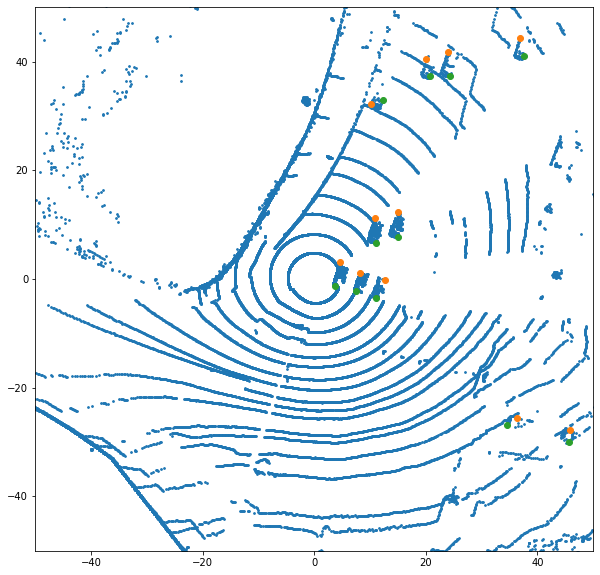

In [73]:
Td_map = collector.aggregated_map[569]
Foreground_map = (Td_map < collector.thred_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= collector.thred_map)&(Td_map != 0)
xy_set,uni_label,Labeling_map_new = extract_xy_interval_merging_TR(Labeling_map,Td_map,Background_map)
pcd = get_pcd_colored(Td_map,Labeling_map_new)
xy = np.asarray(pcd.points)[:,[0,1]]
plt.figure(figsize=(10,10))
plt.scatter(xy[:,0],xy[:,1],s = 3)
plt.scatter(xy_set[:,0,0],xy_set[:,0,1])
plt.scatter(xy_set[:,1,0],xy_set[:,1,1])
plt.ylim(-50,50)
plt.xlim(-50,50)
plt.show()

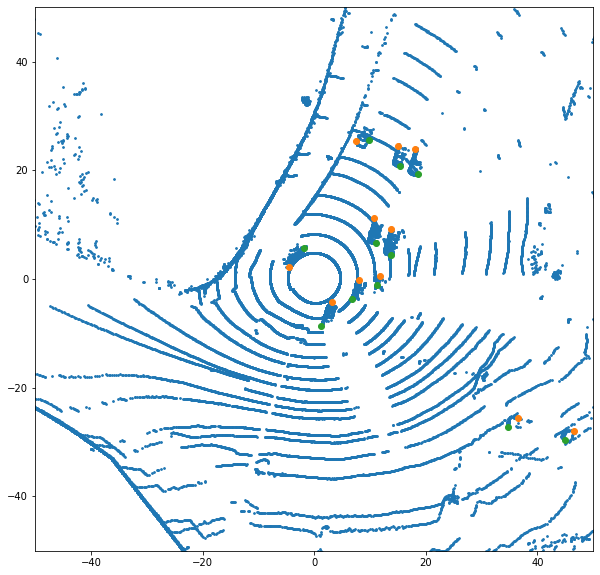

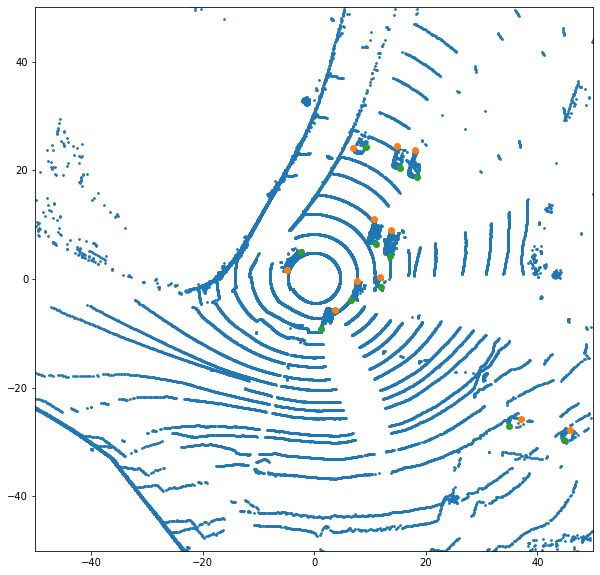

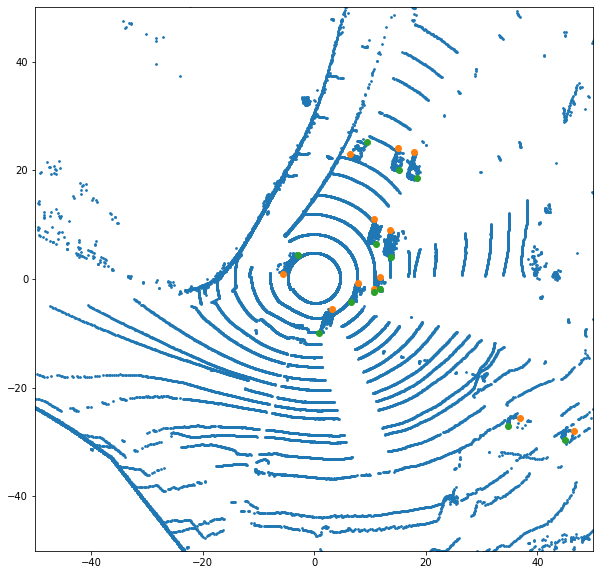

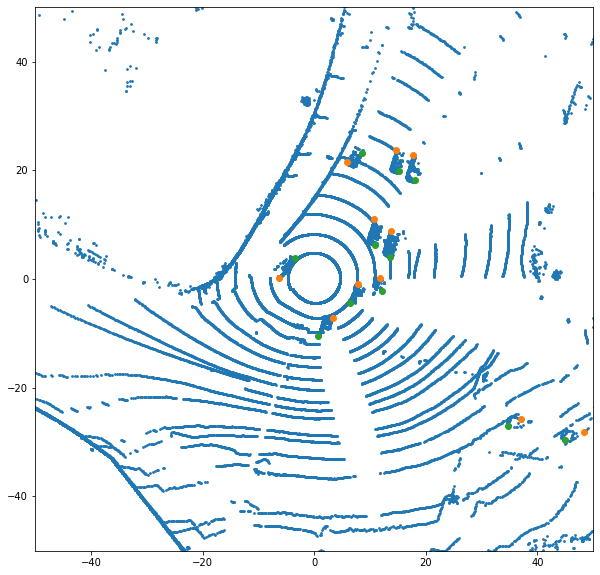

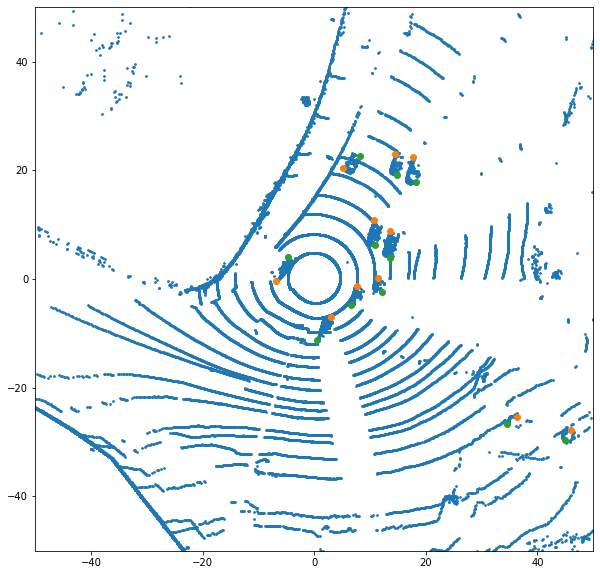

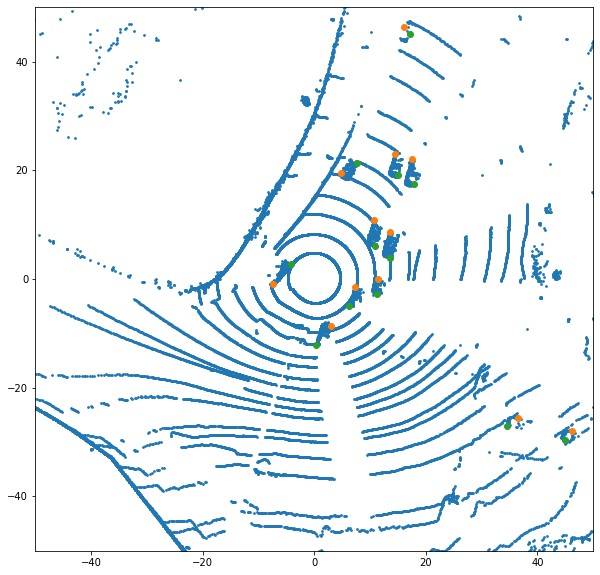

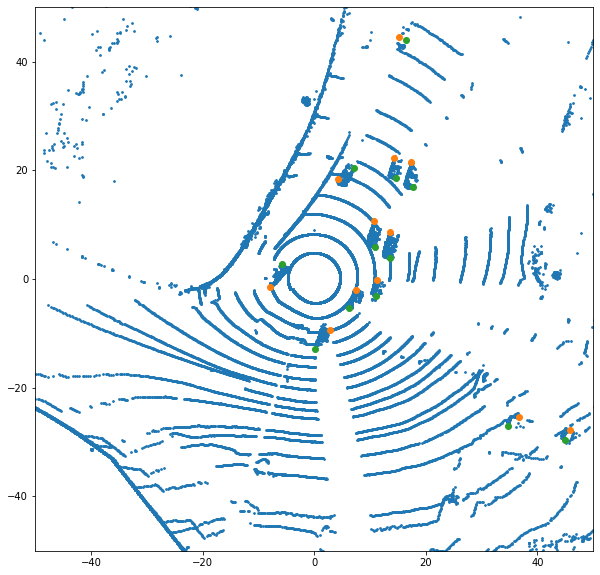

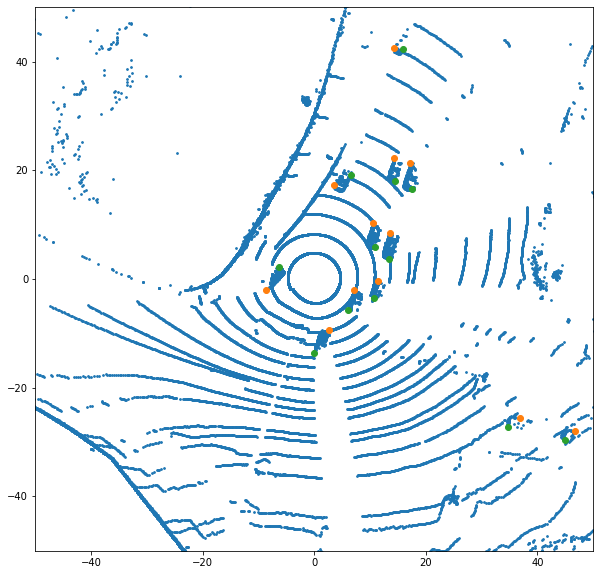

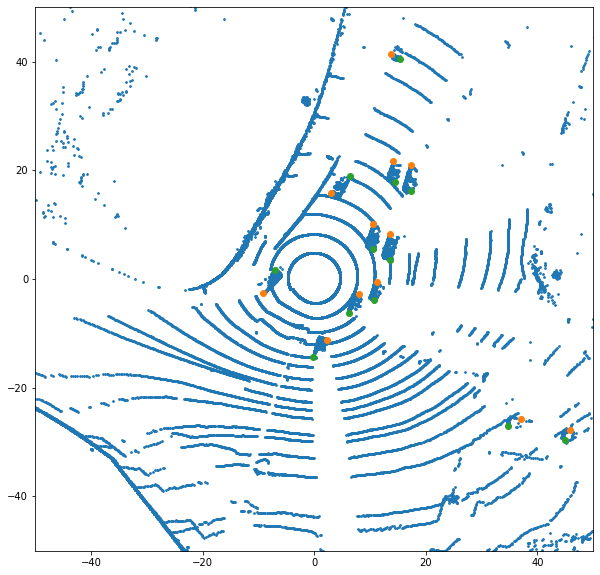

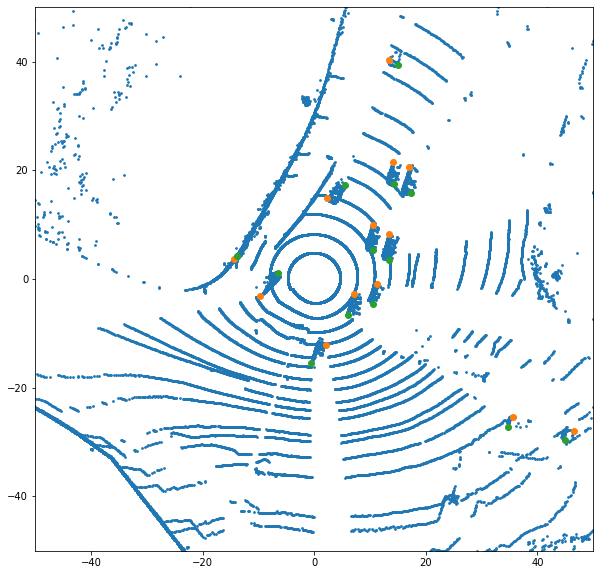

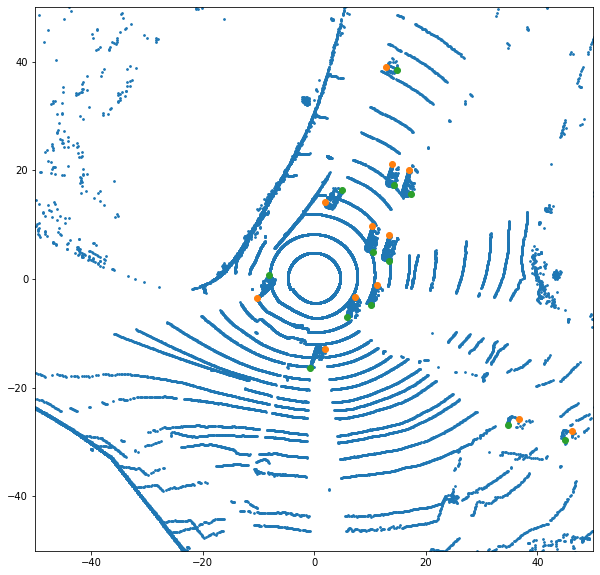

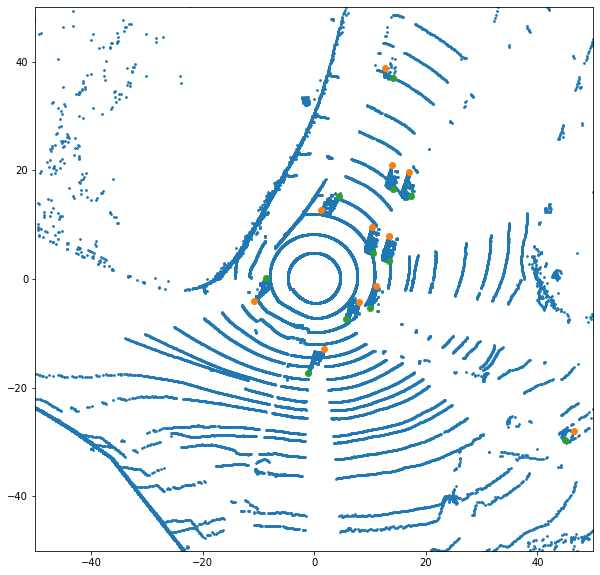

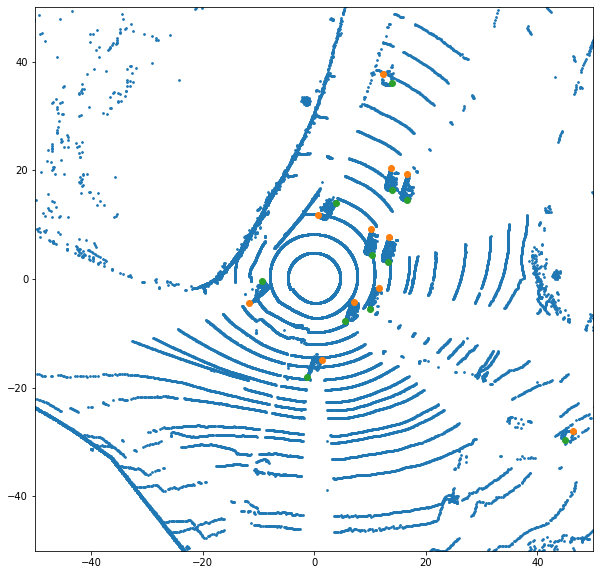

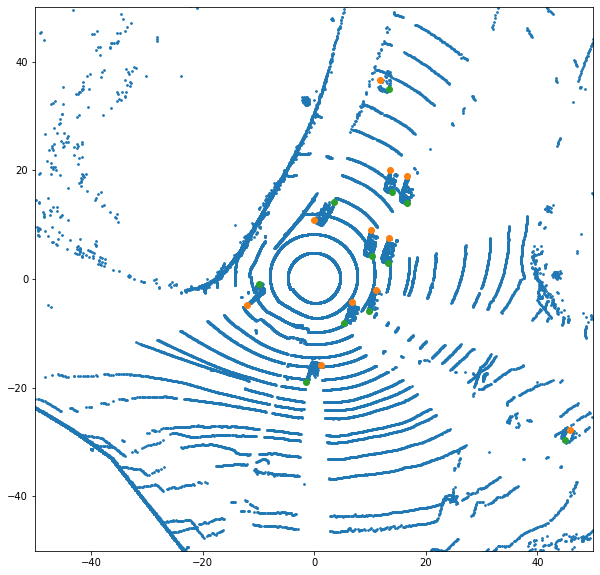

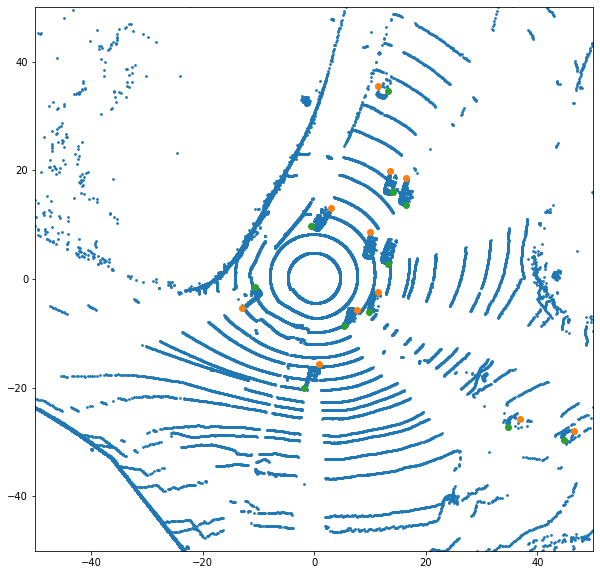

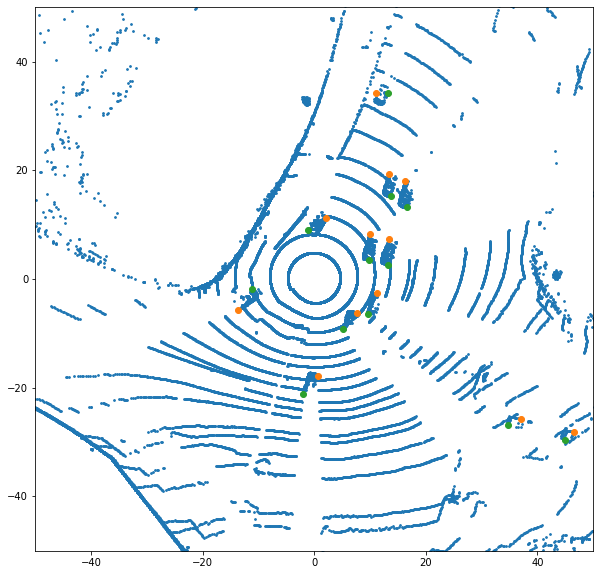

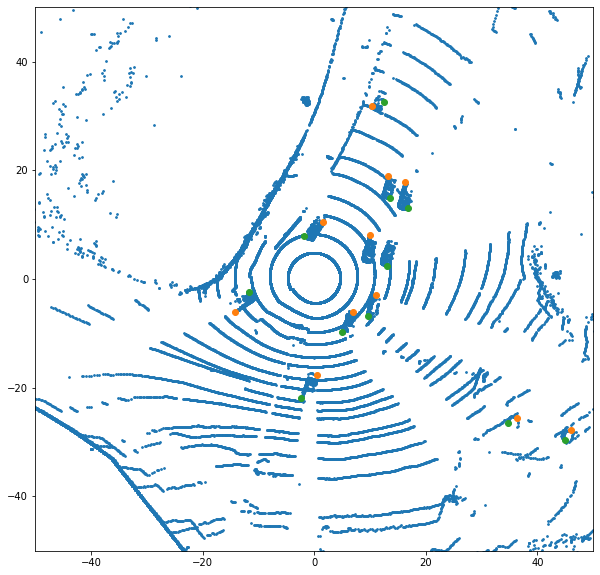

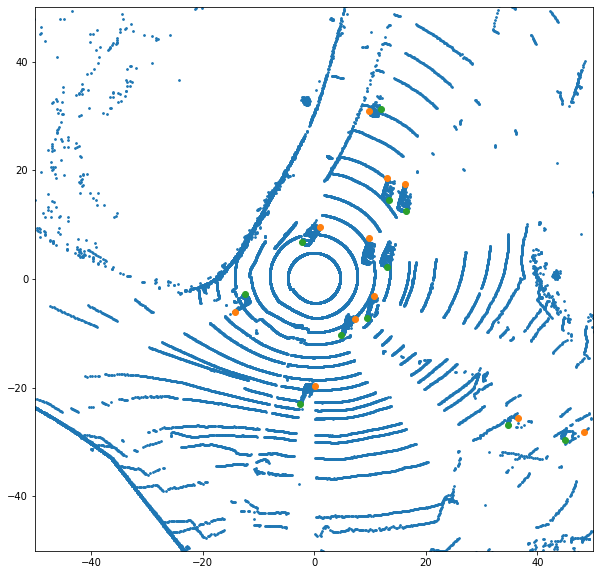

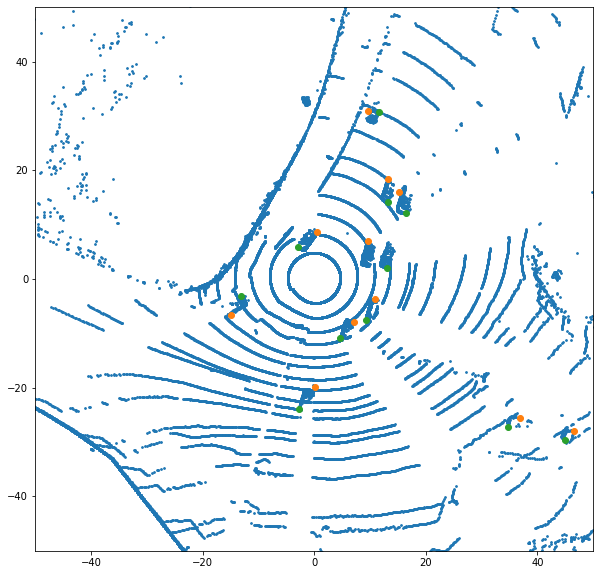

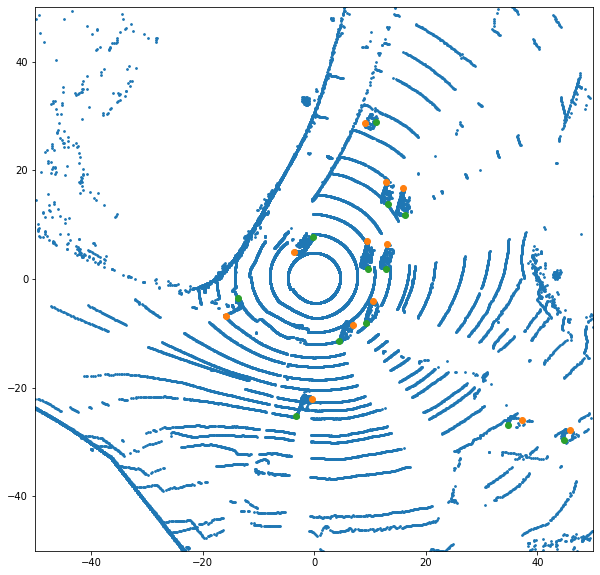

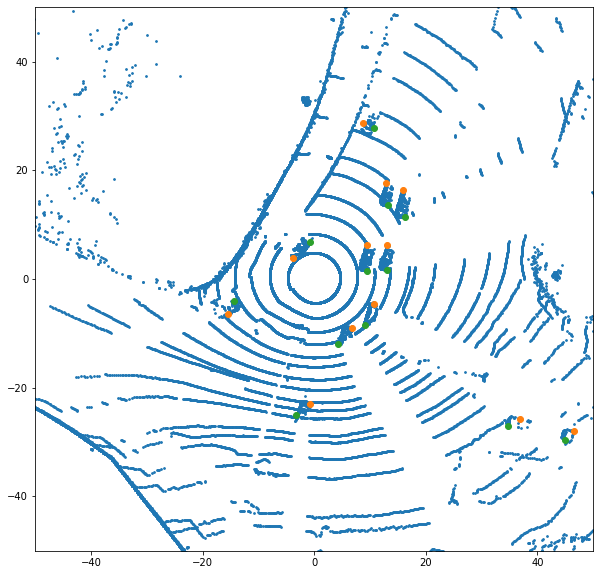

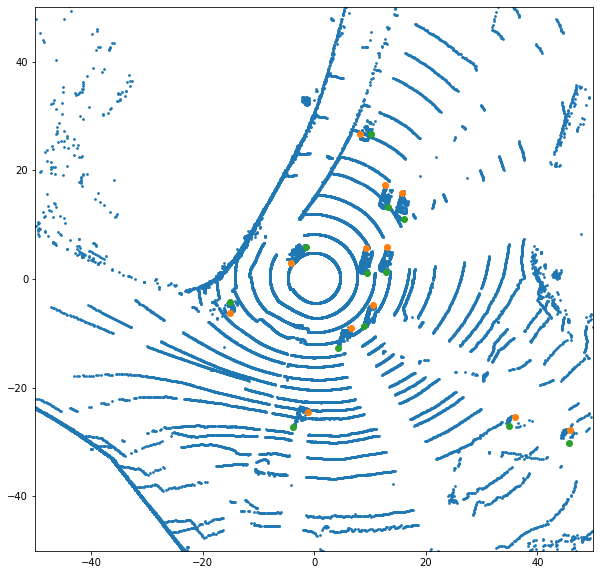

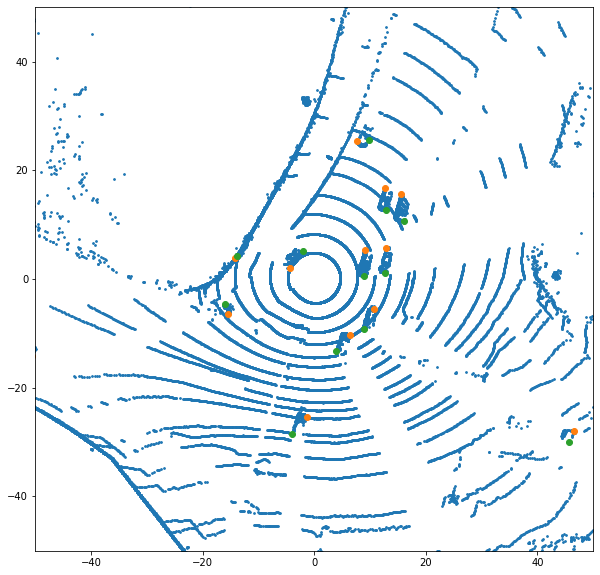

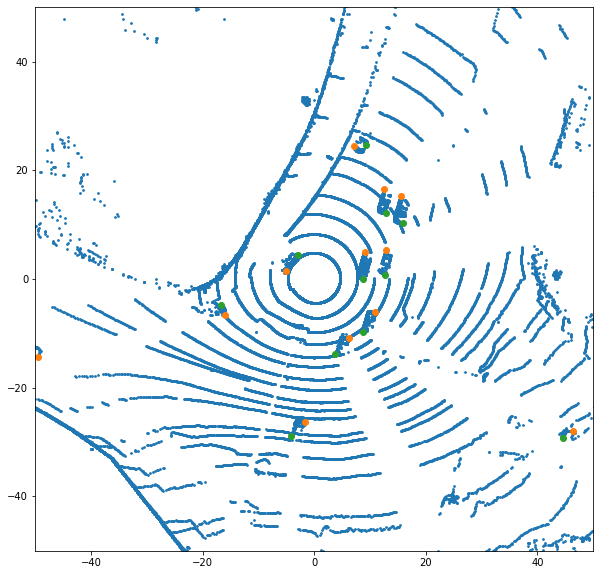

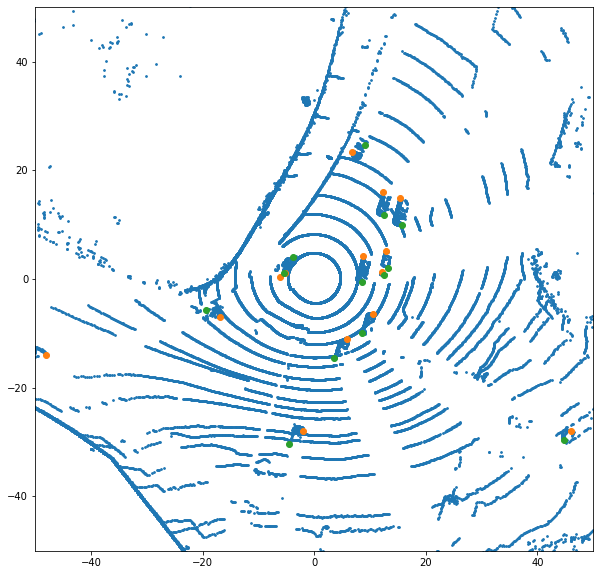

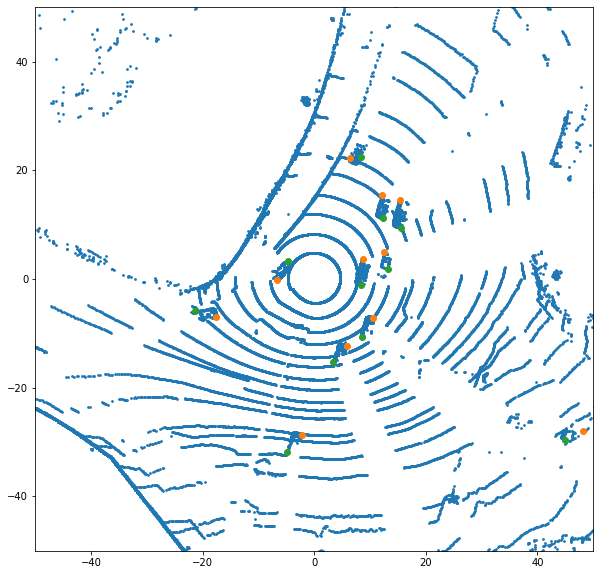

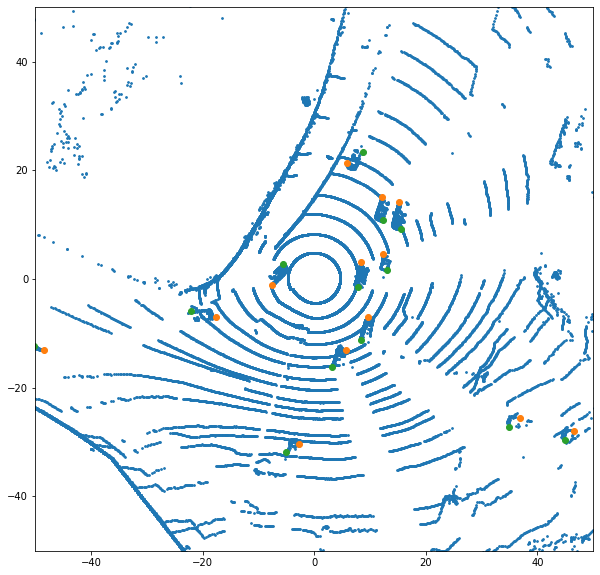

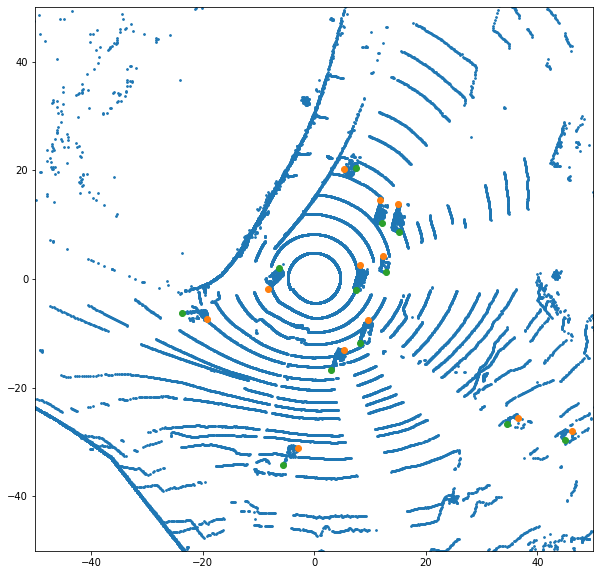

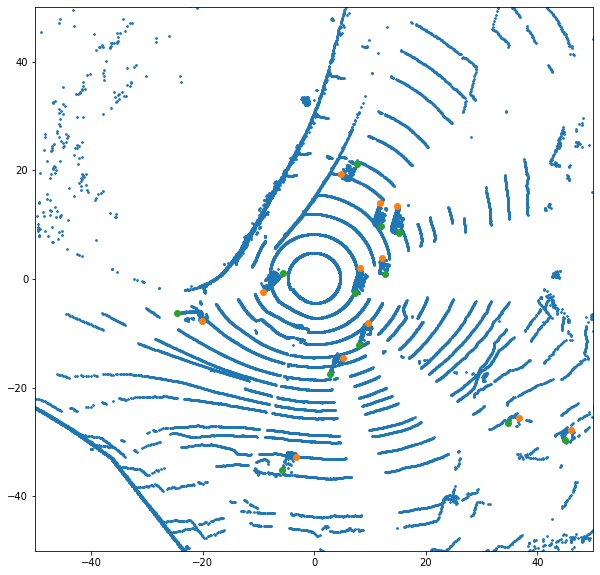

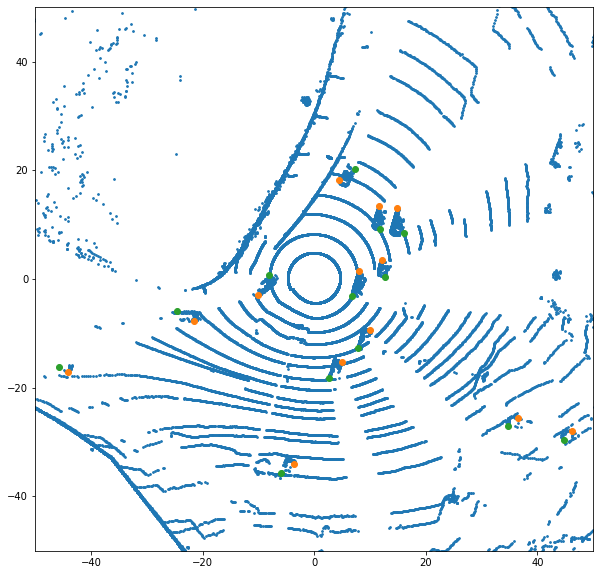

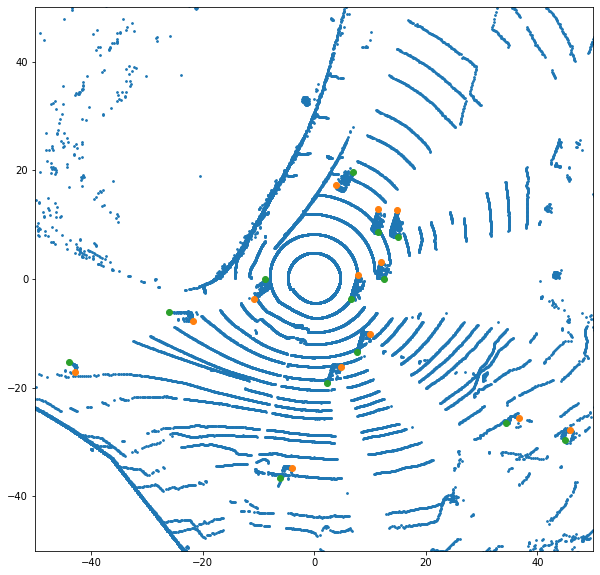

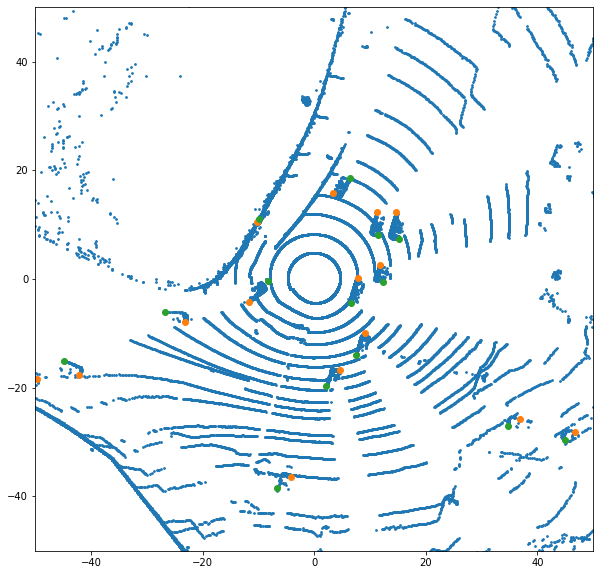

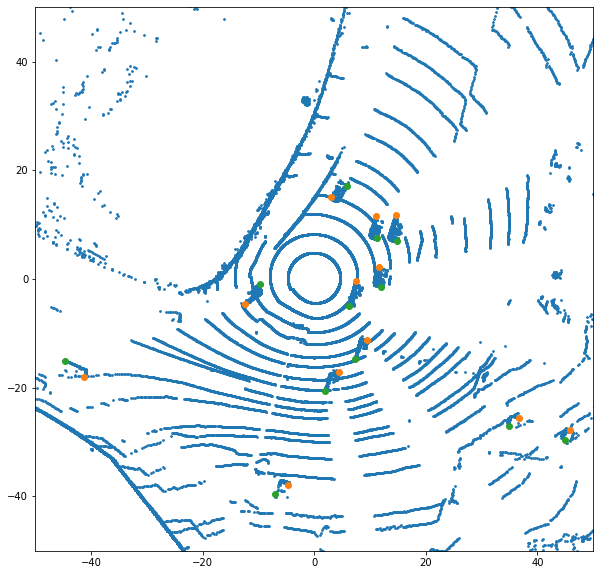

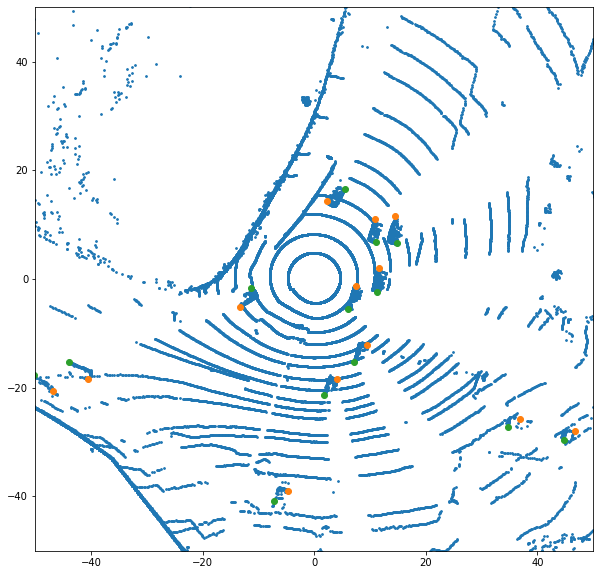

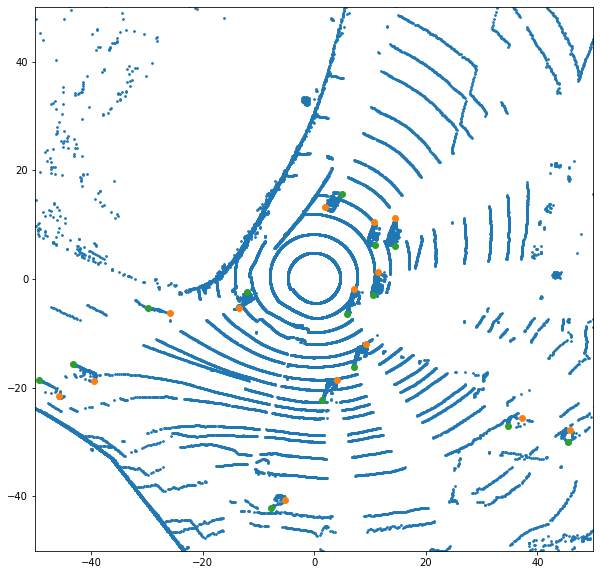

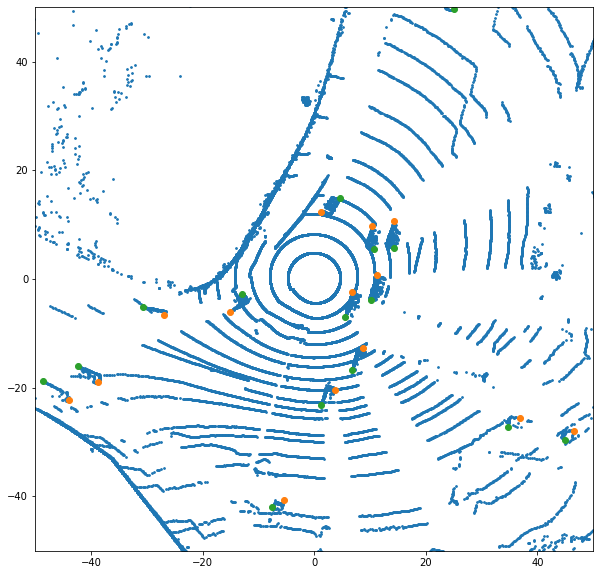

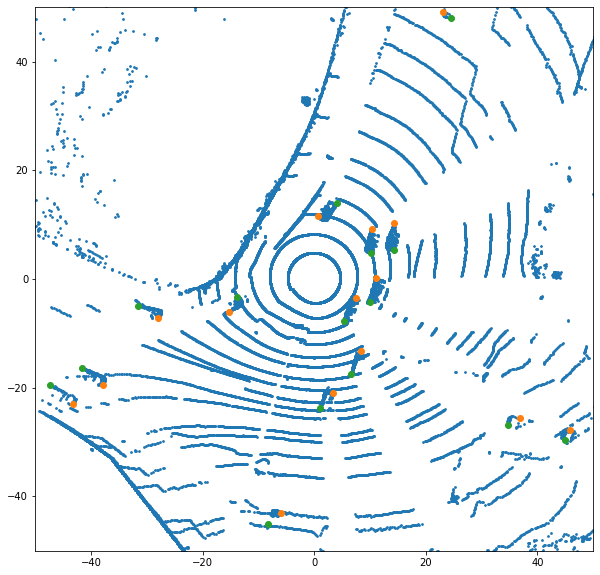

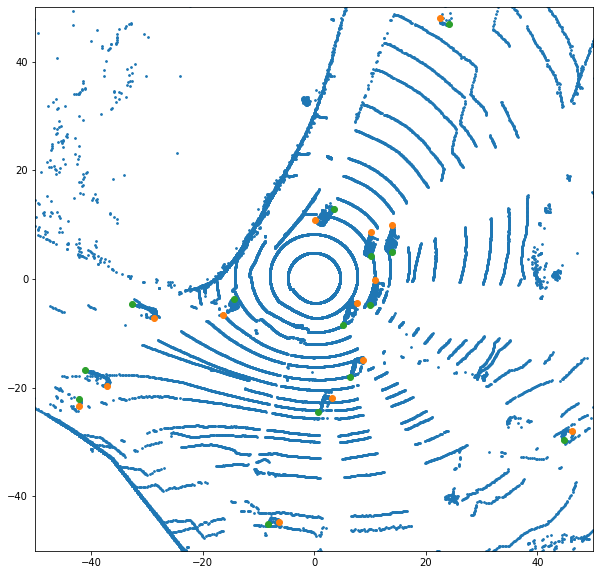

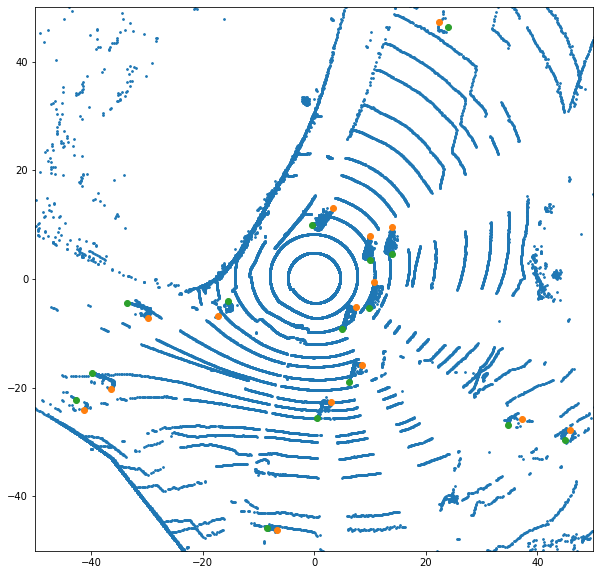

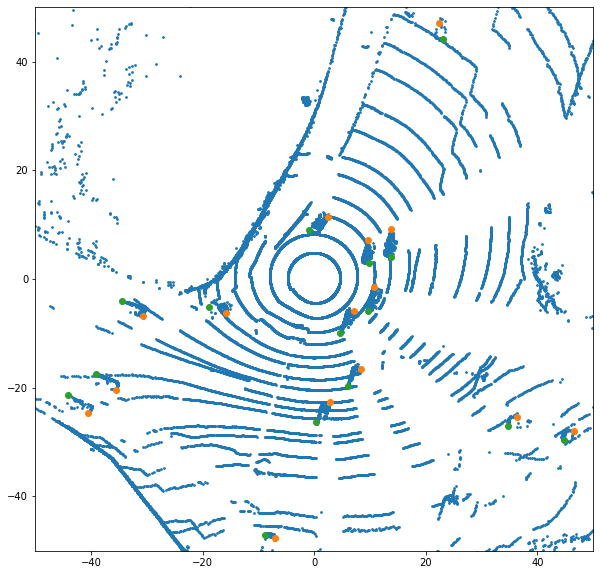

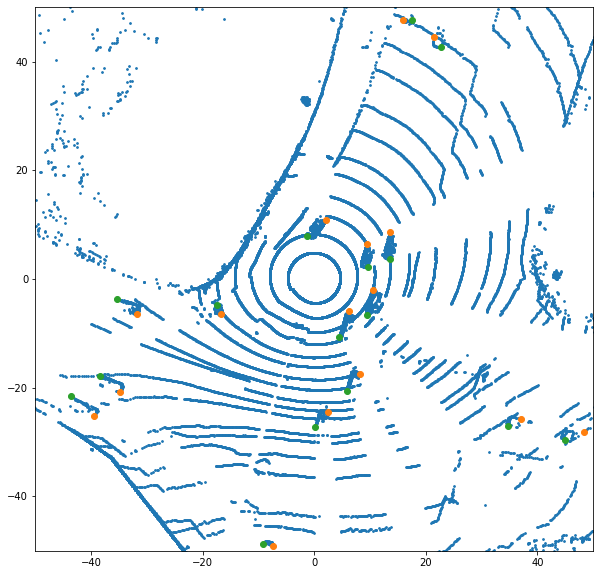

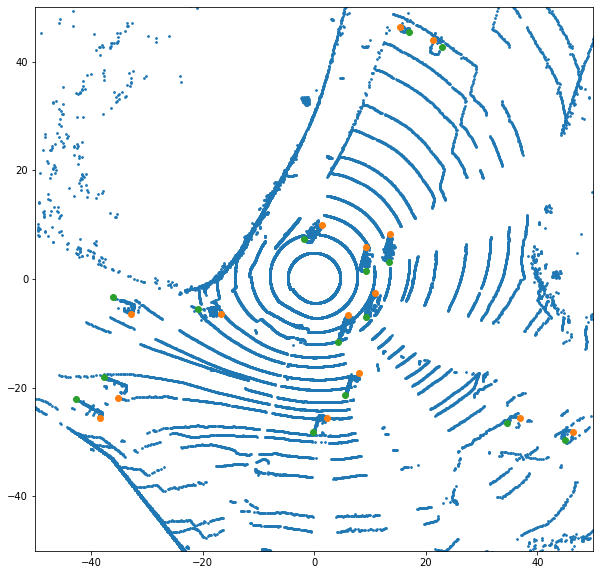

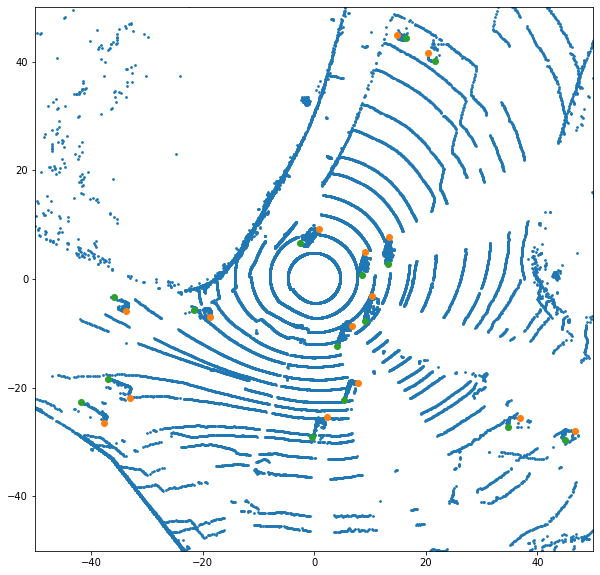

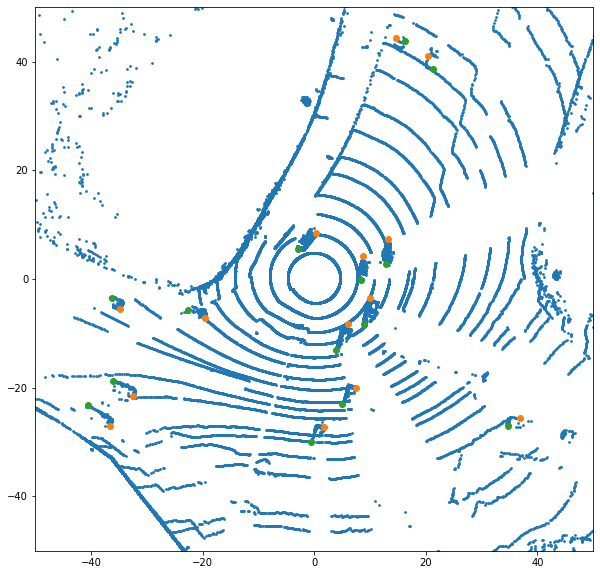

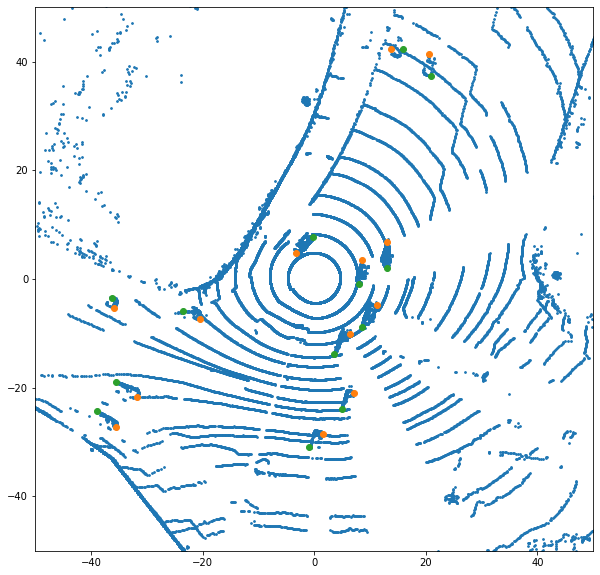

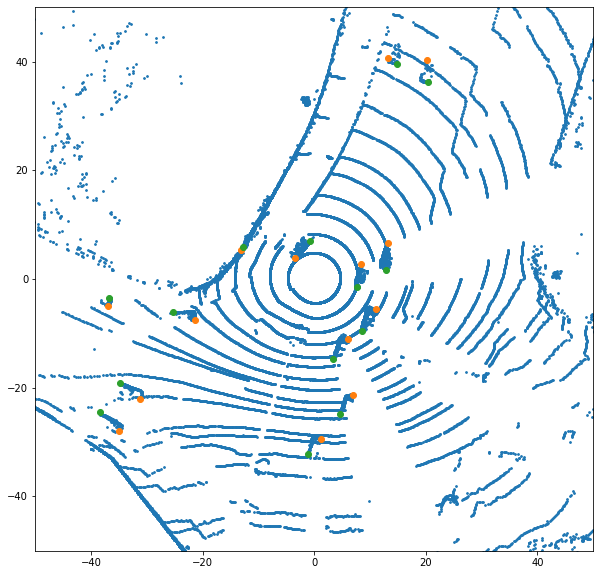

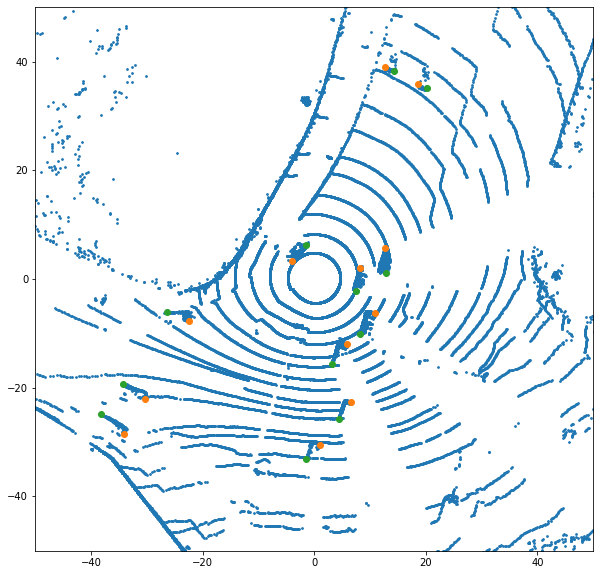

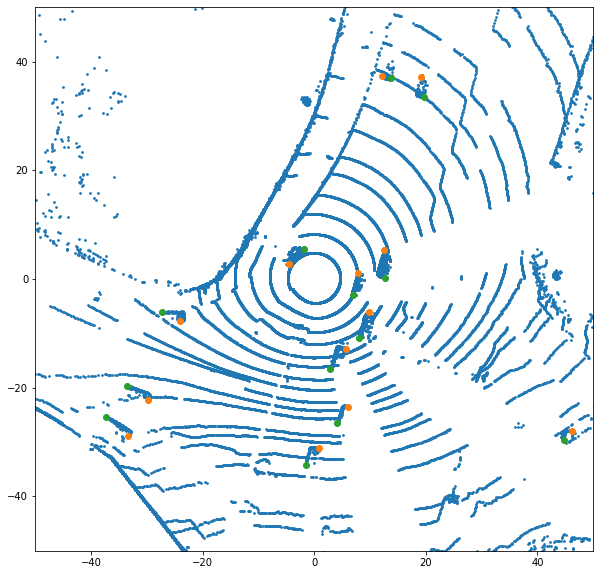

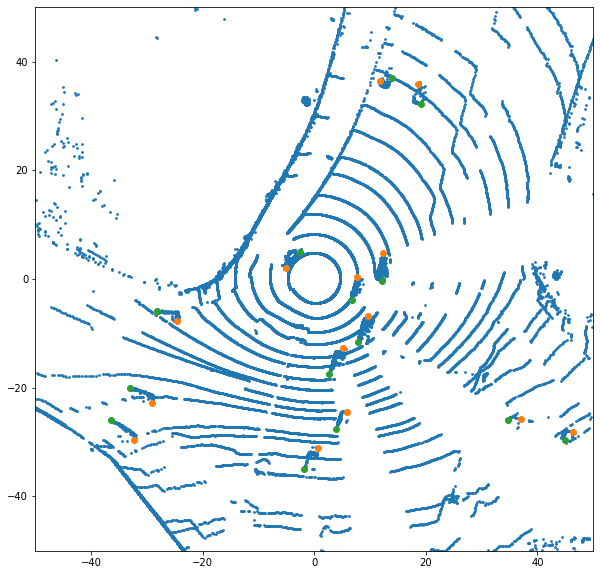

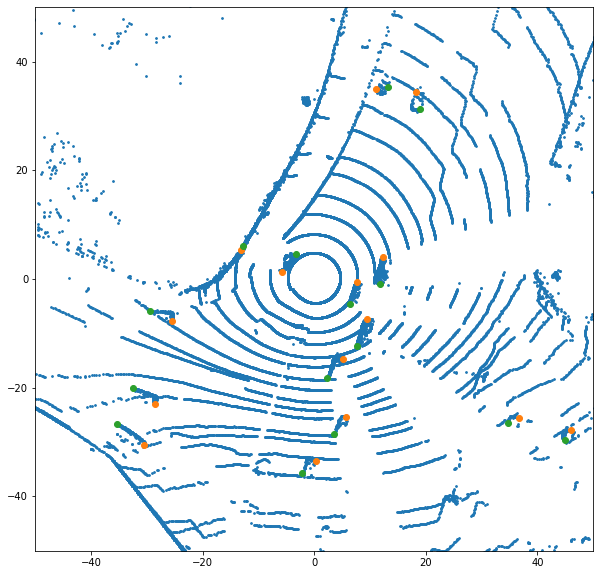

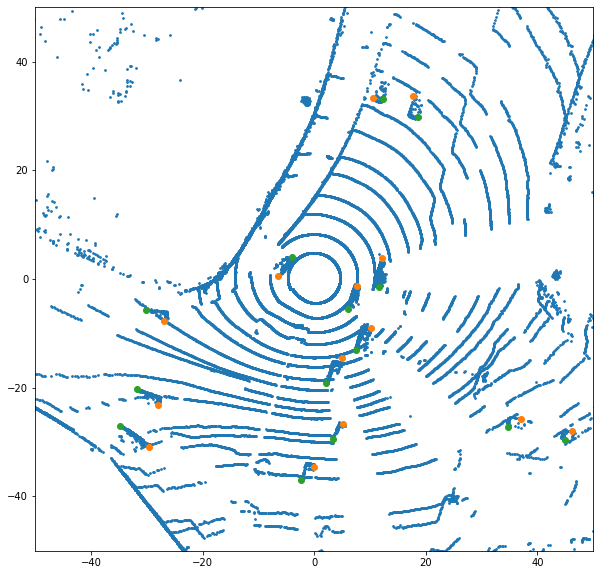

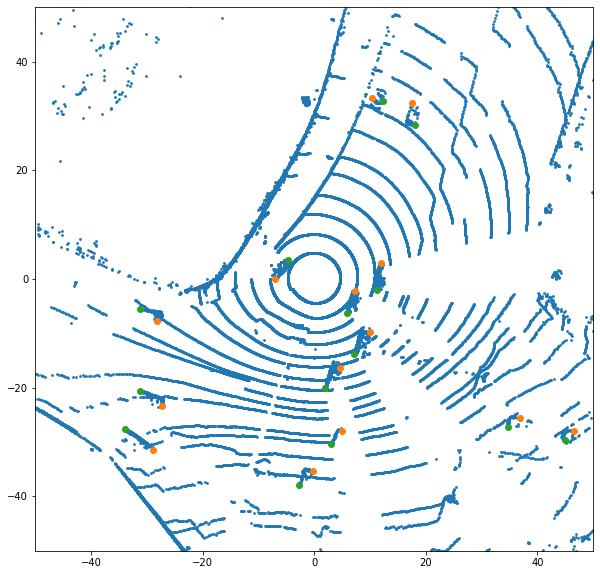

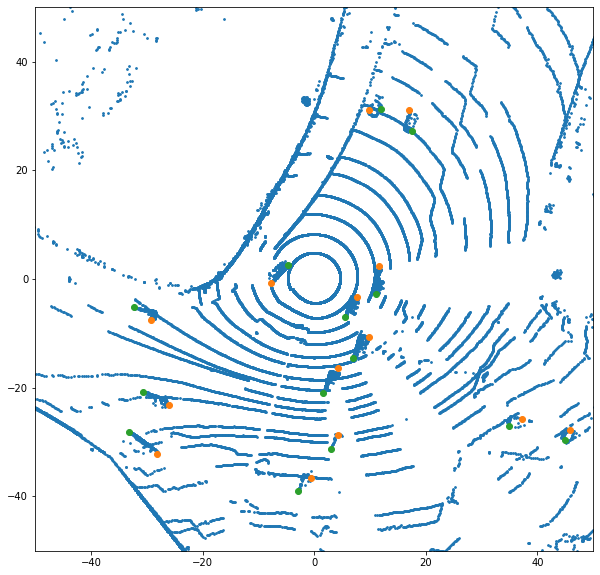

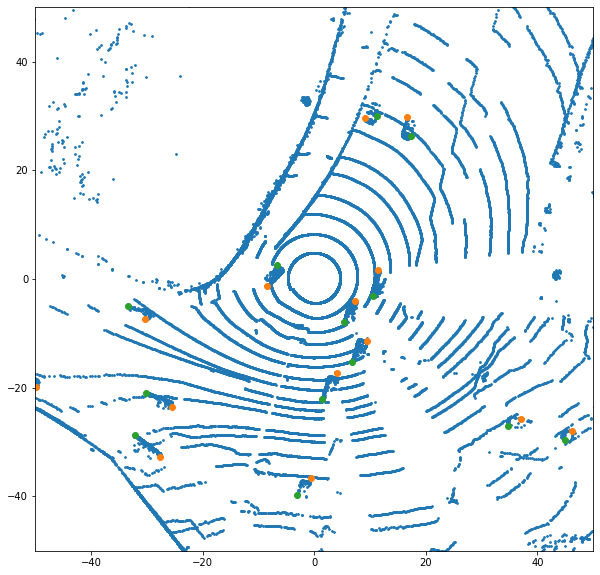

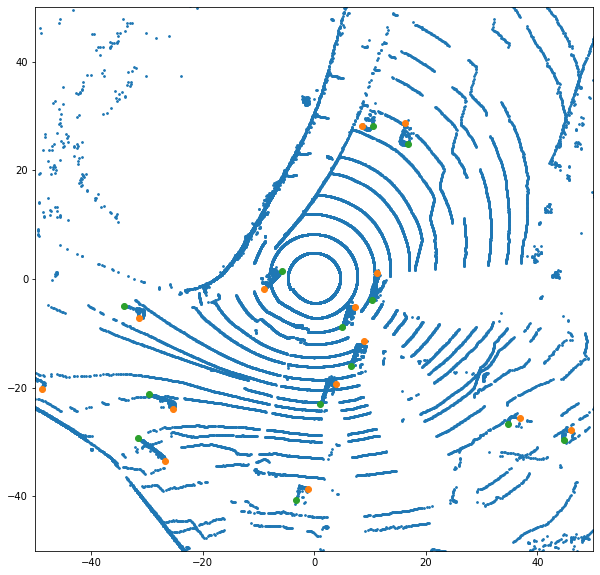

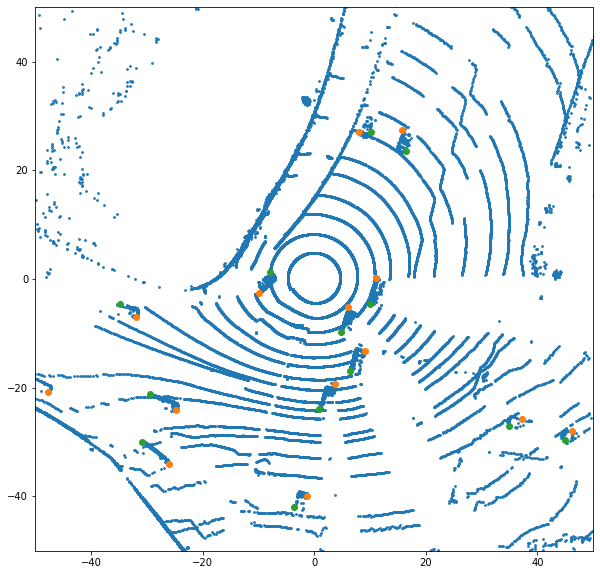

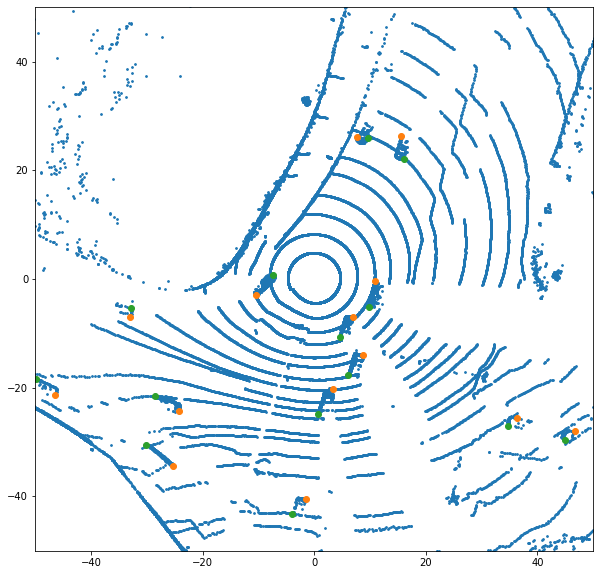

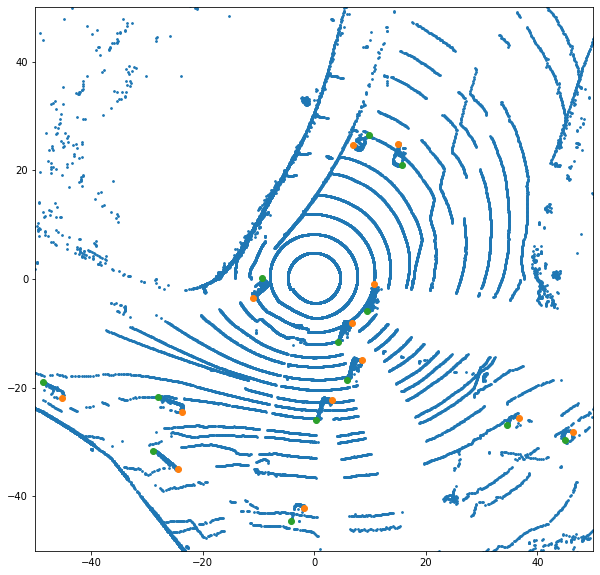

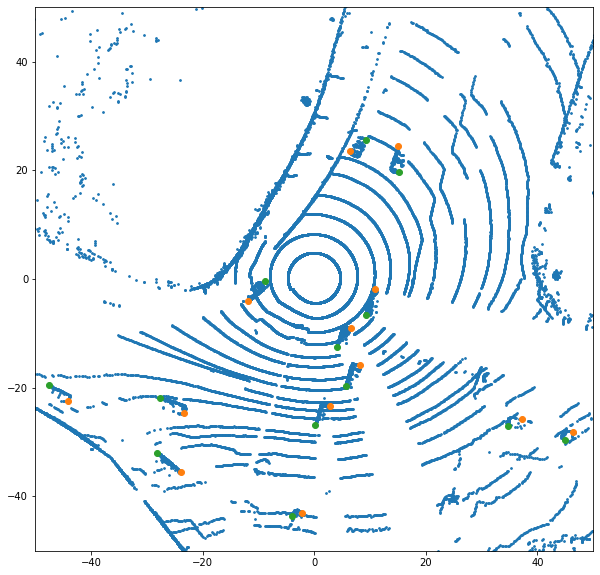

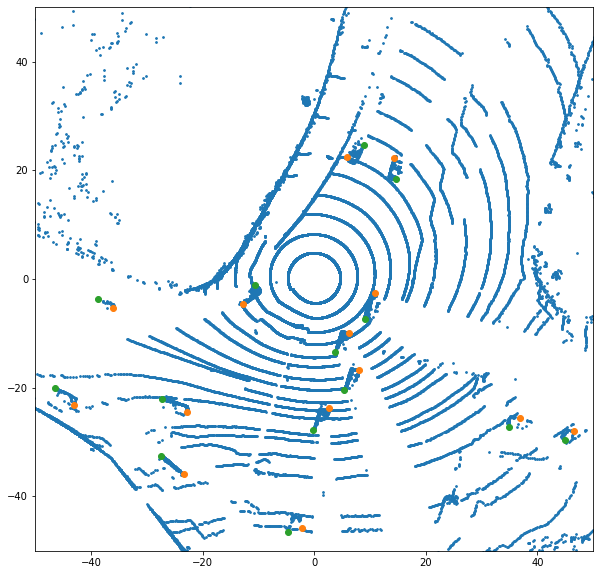

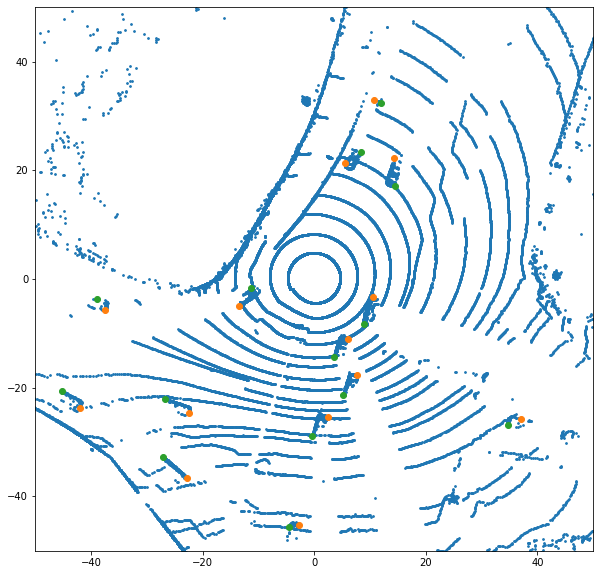

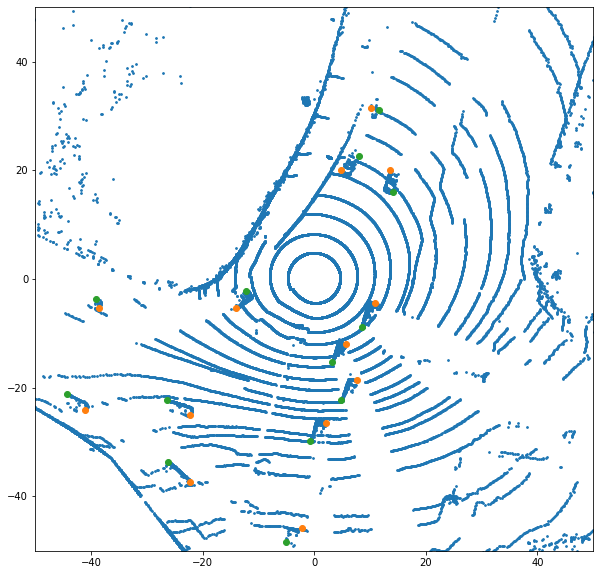

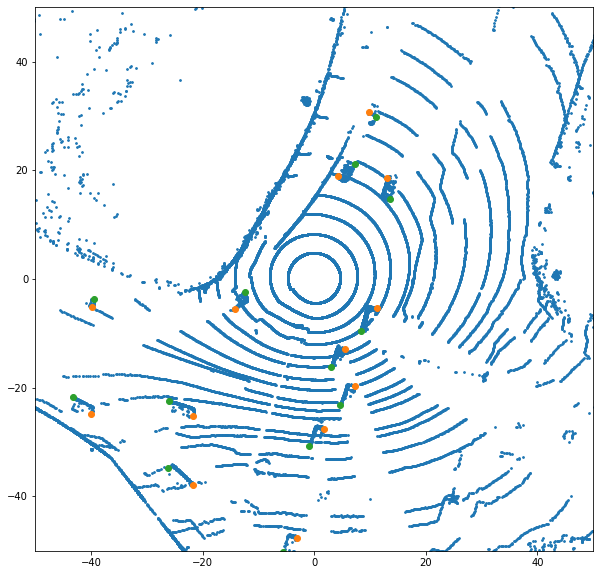

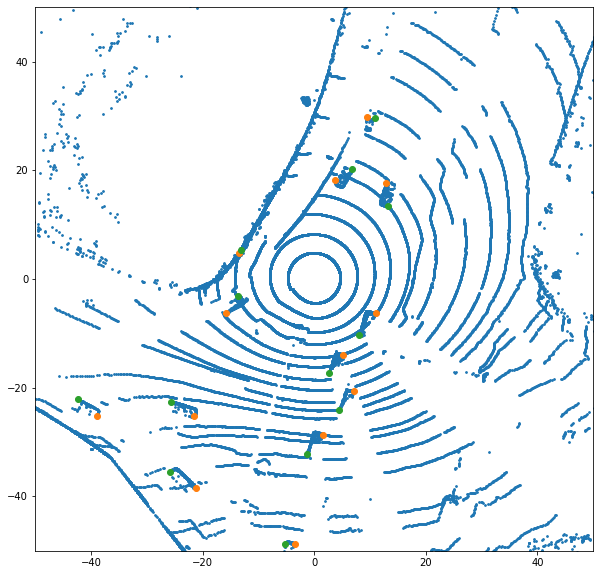

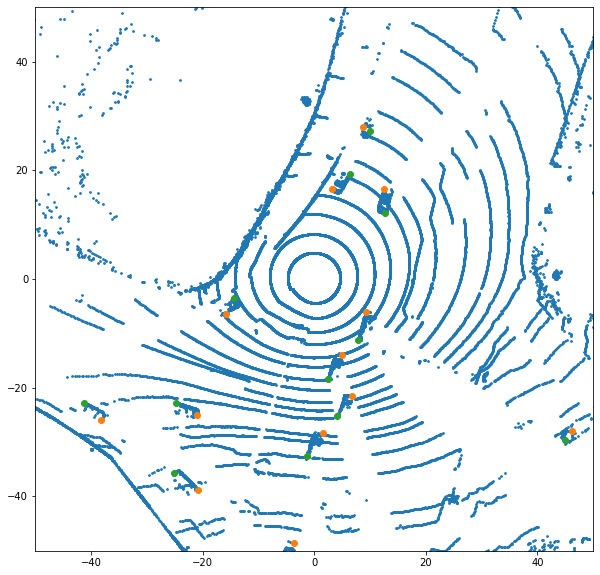

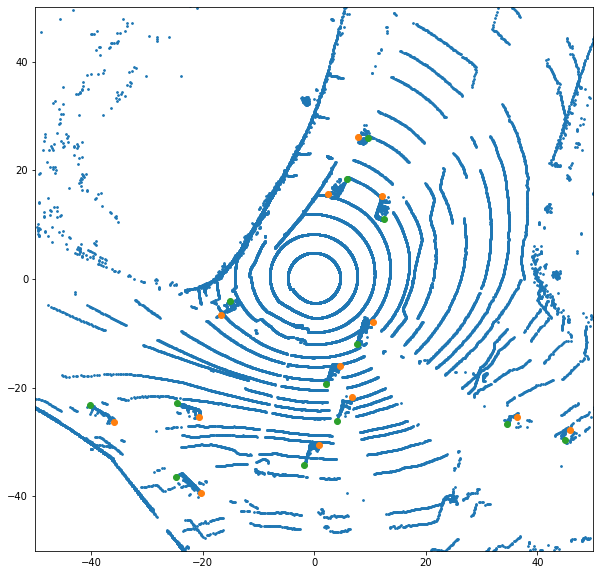

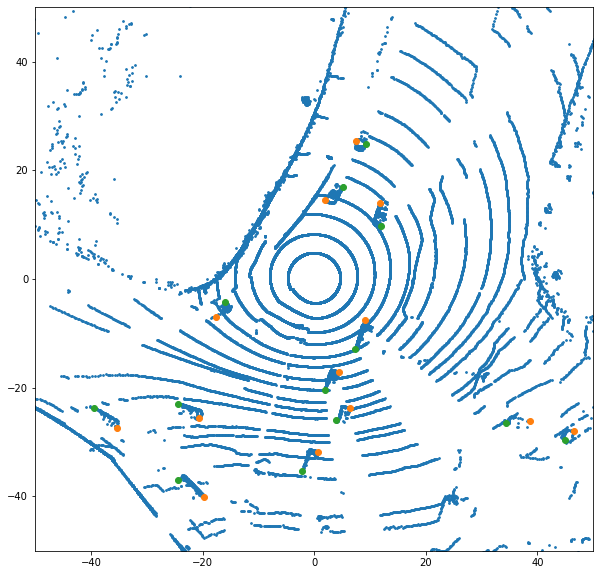

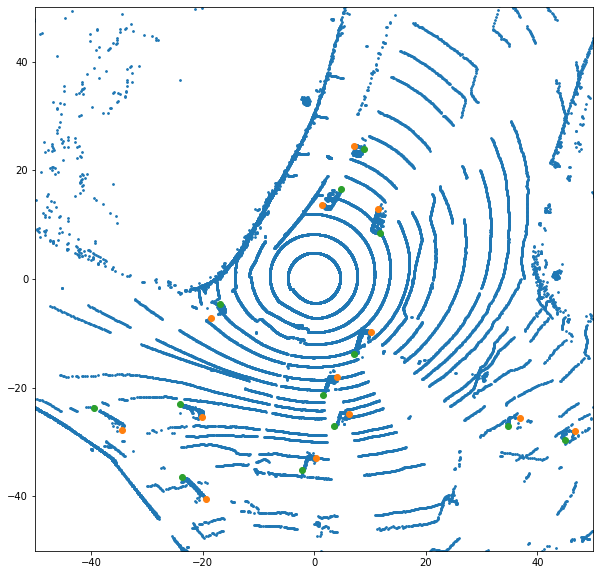

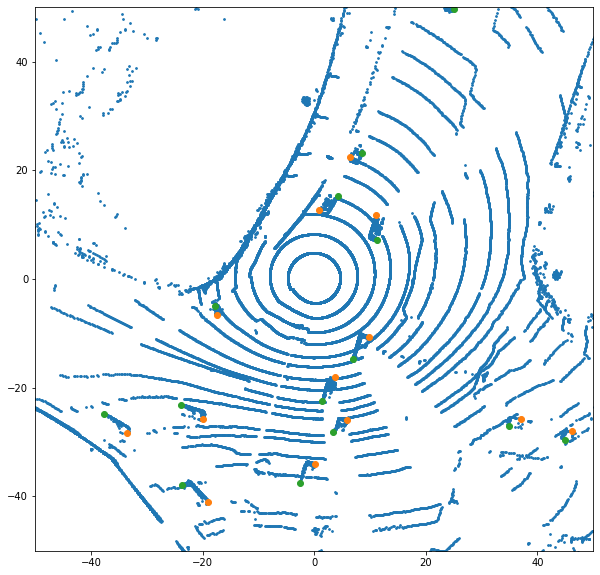

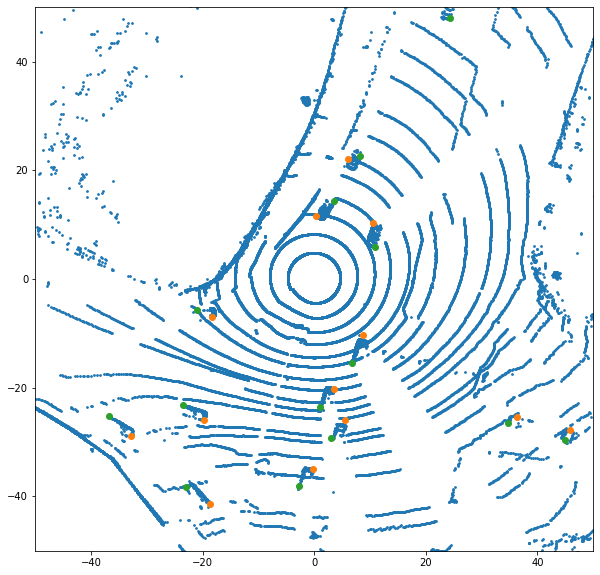

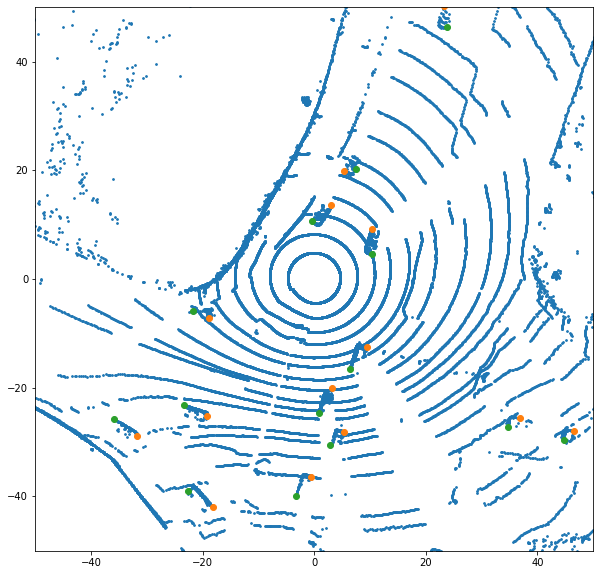

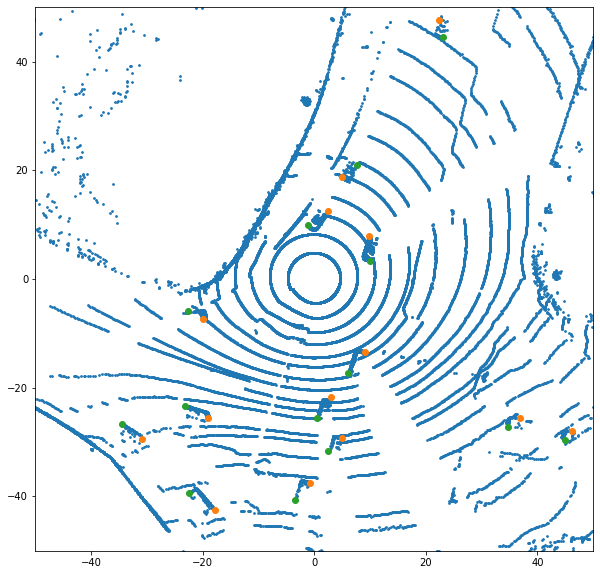

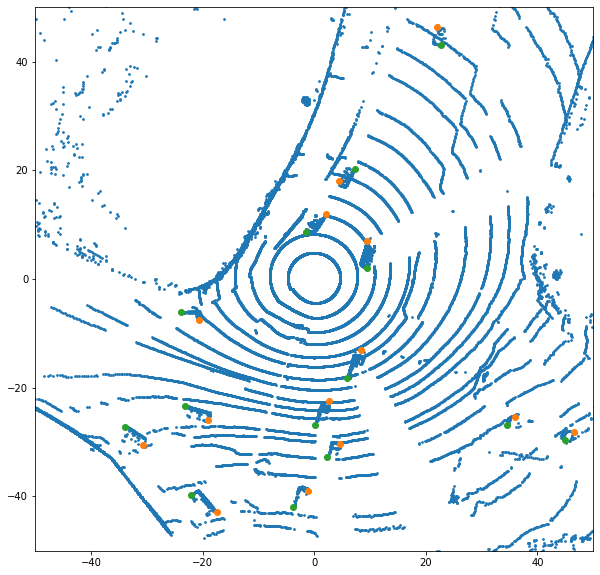

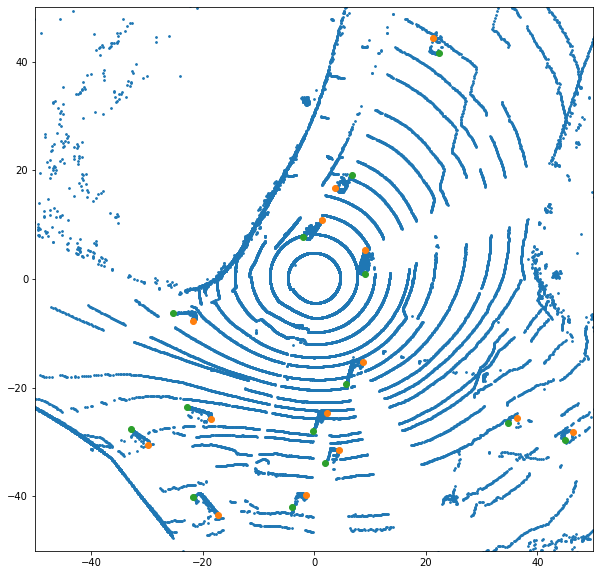

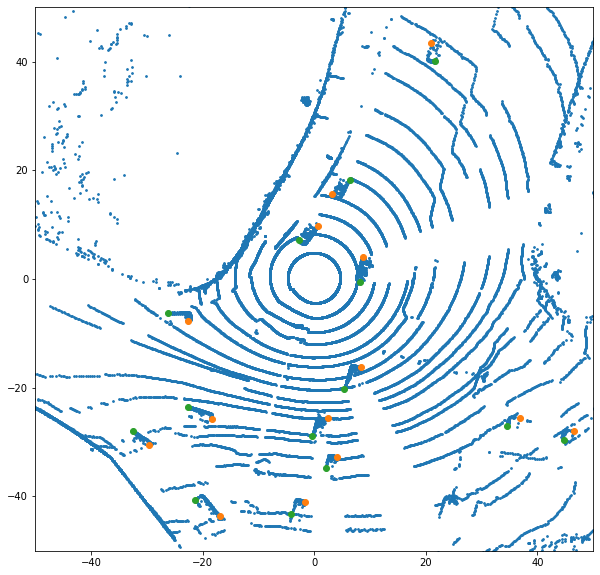

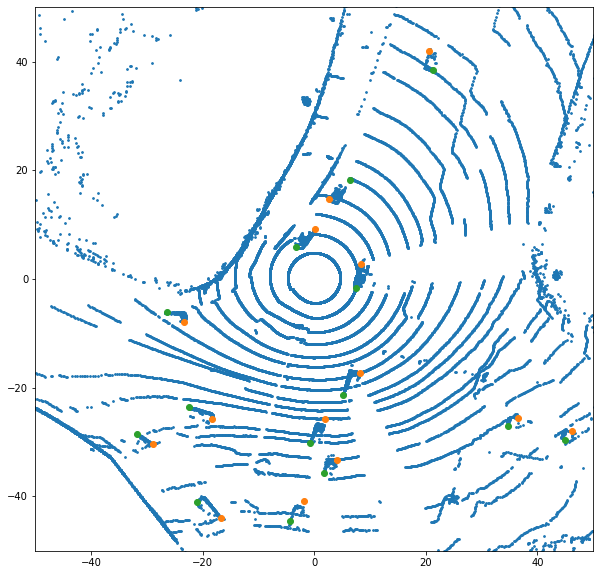

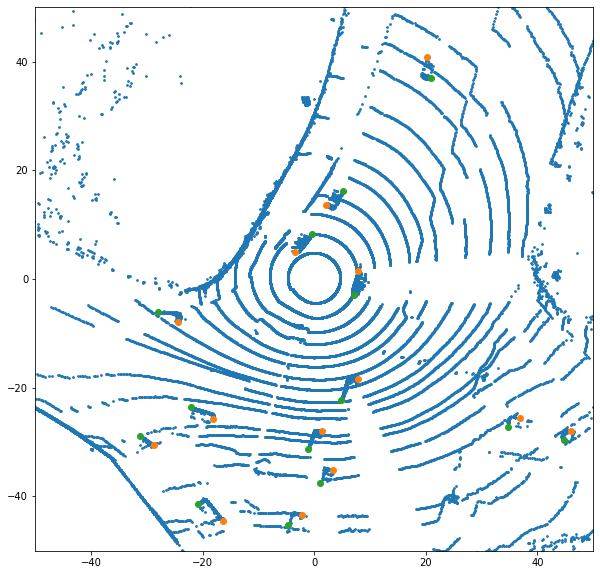

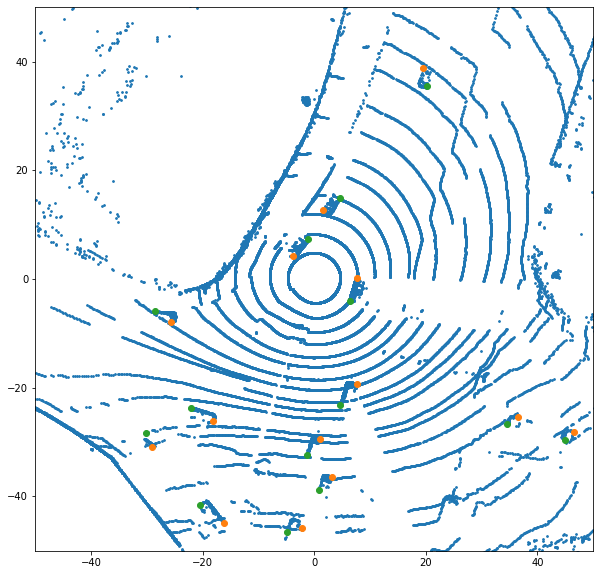

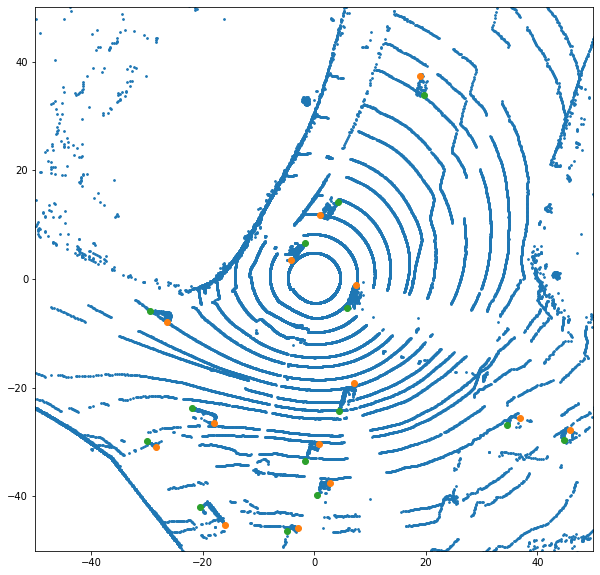

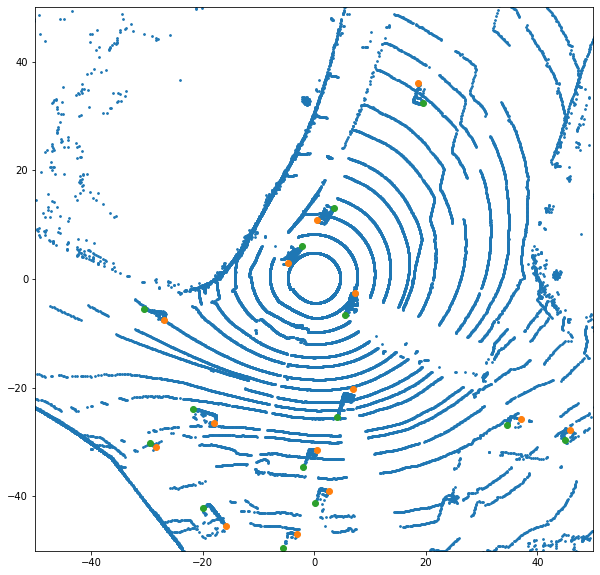

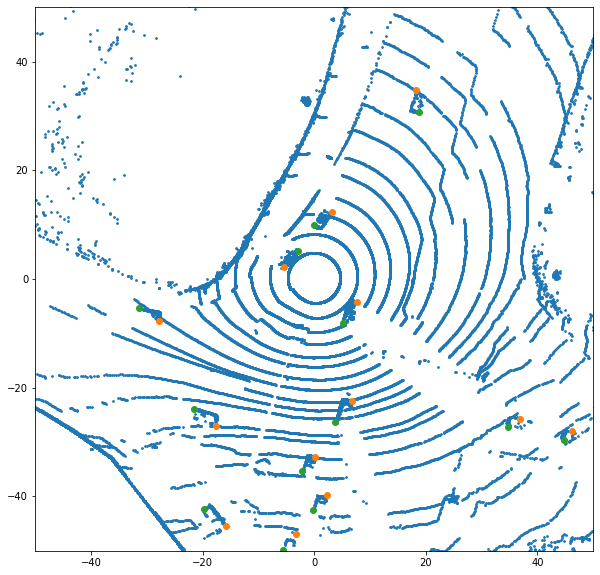

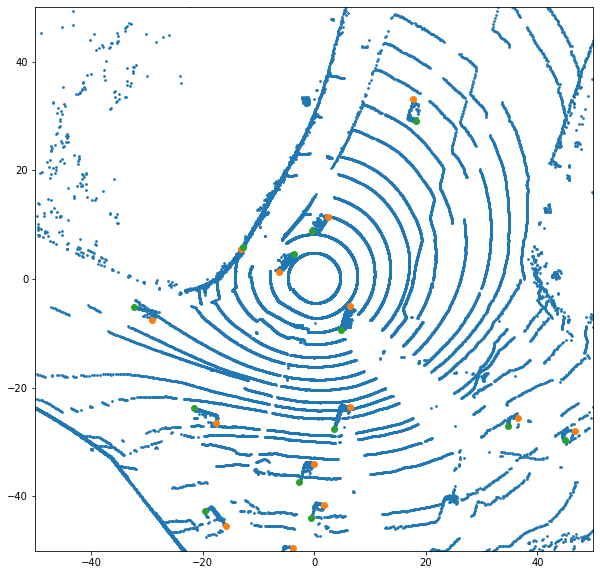

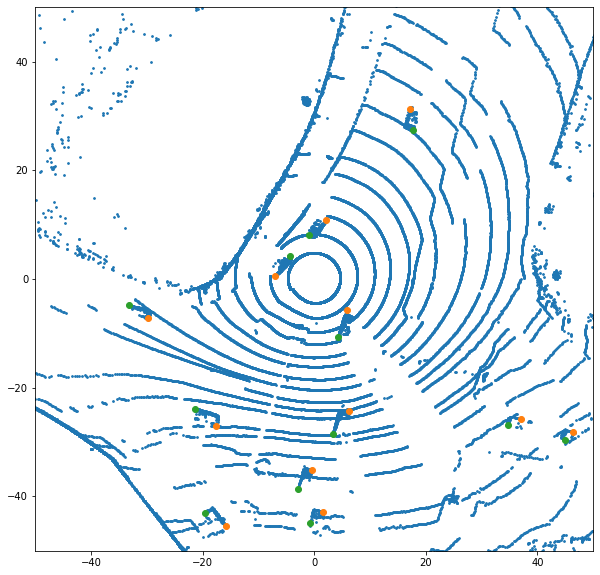

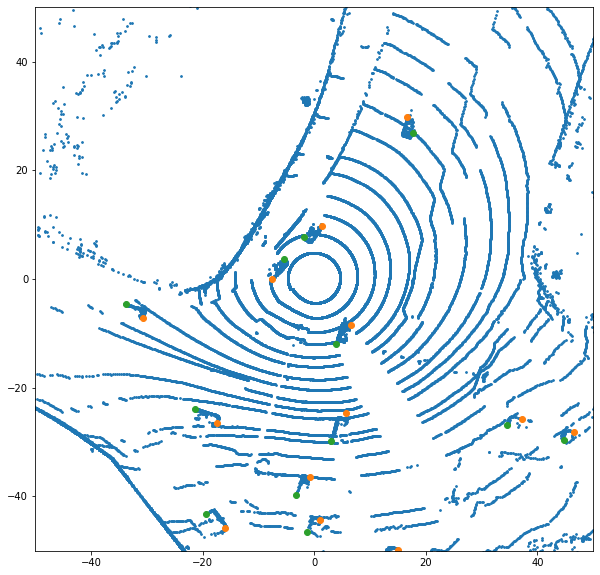

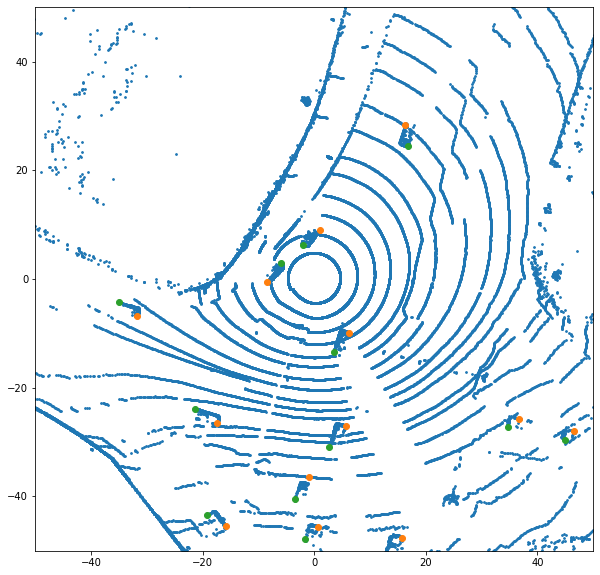

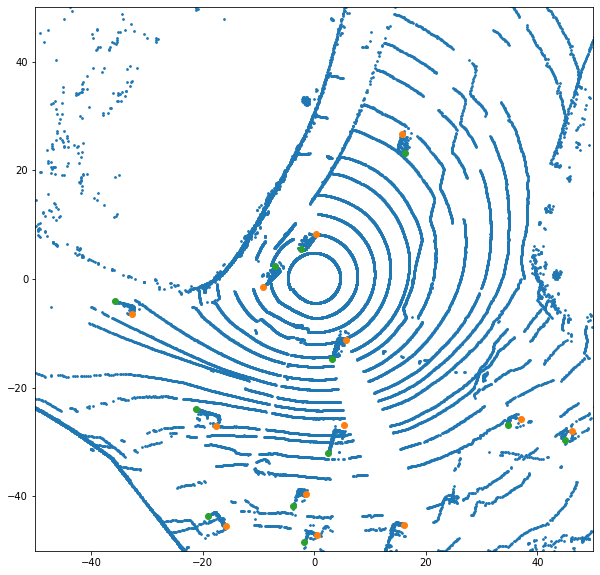

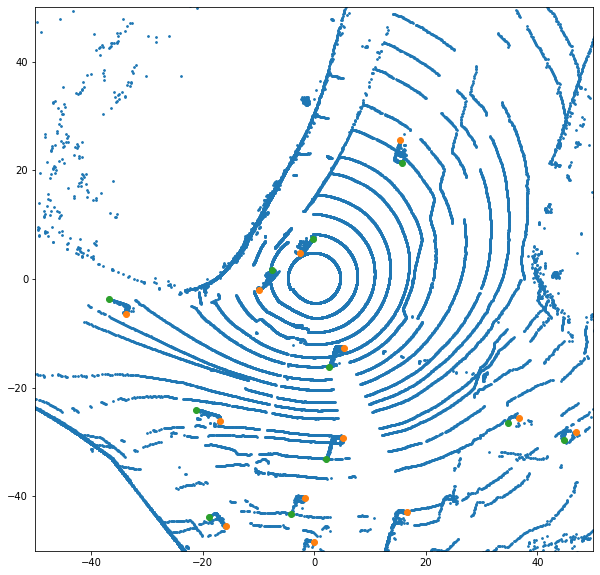

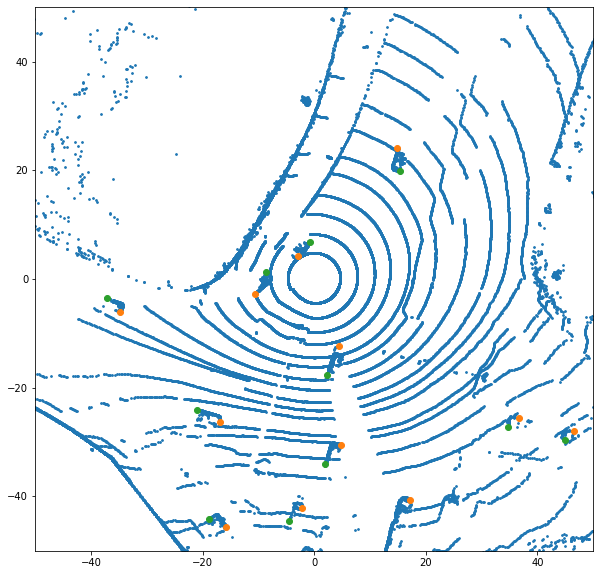

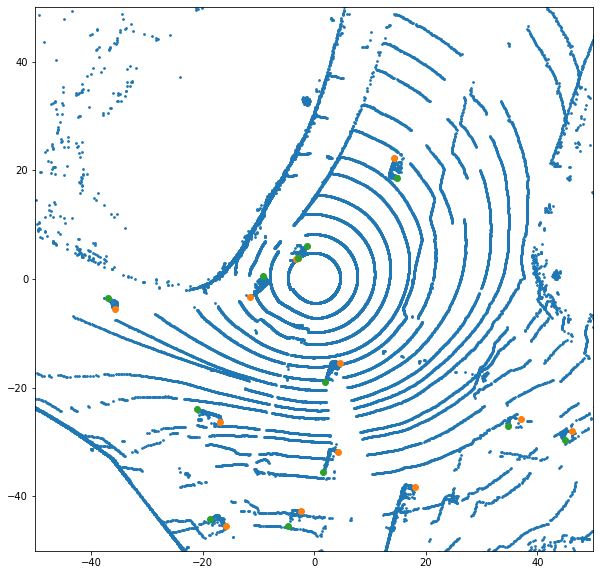

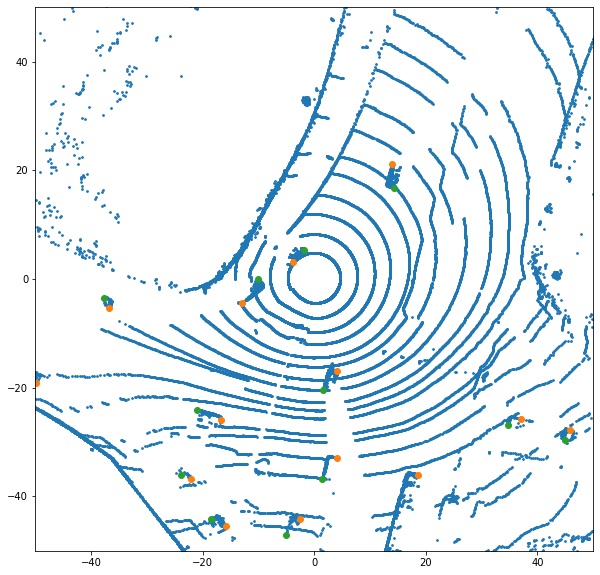

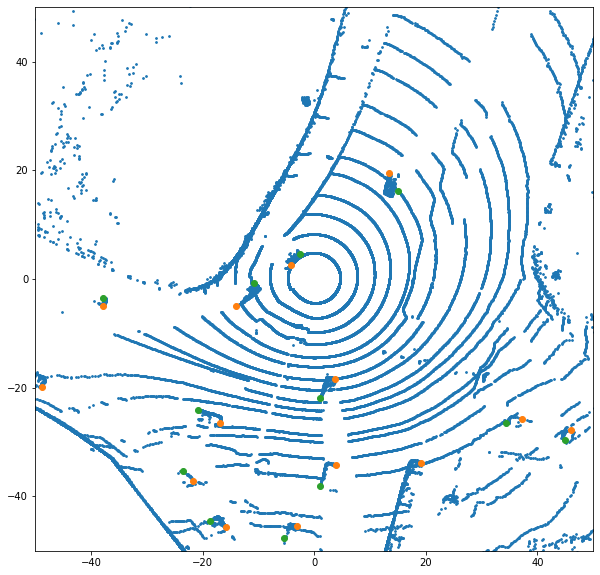

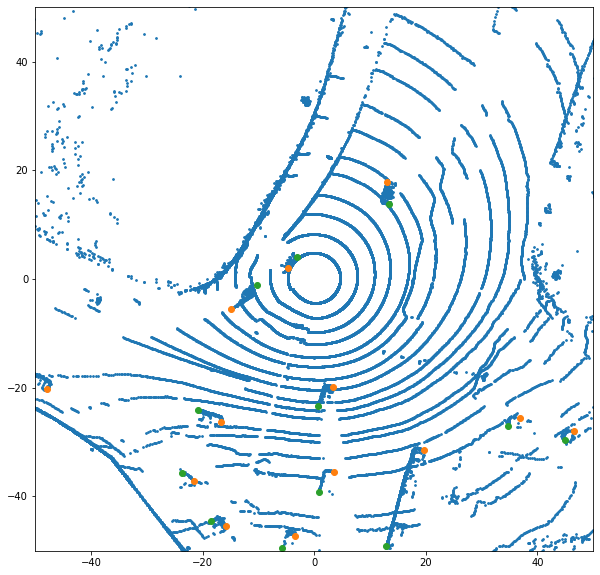

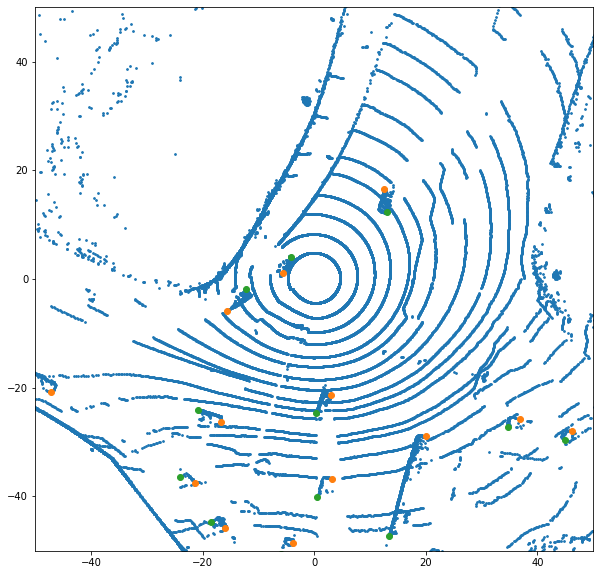

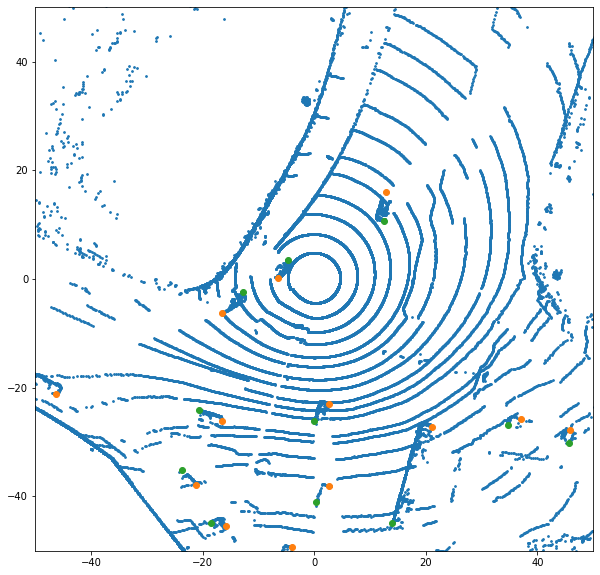

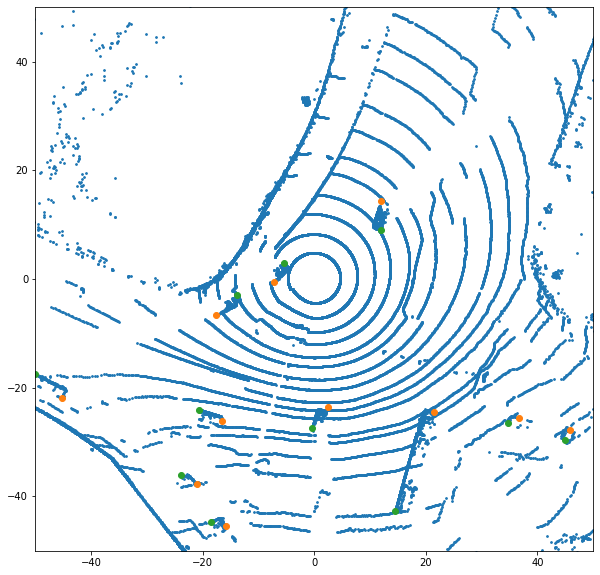

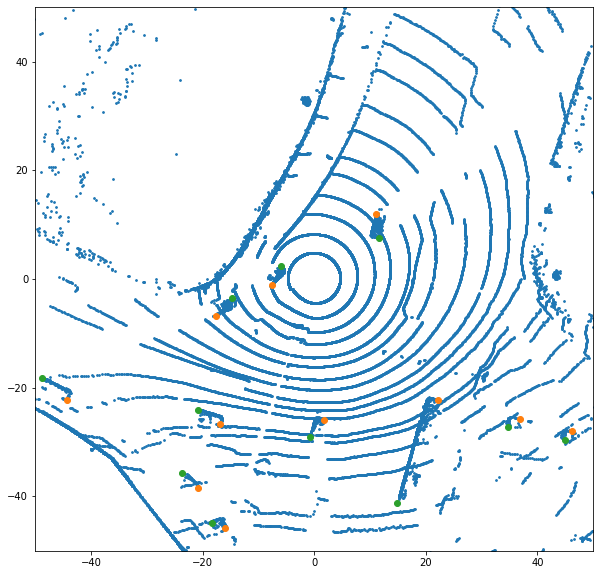

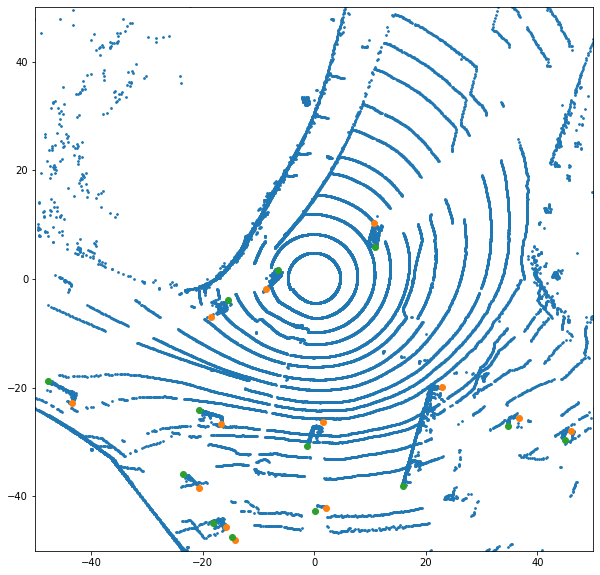

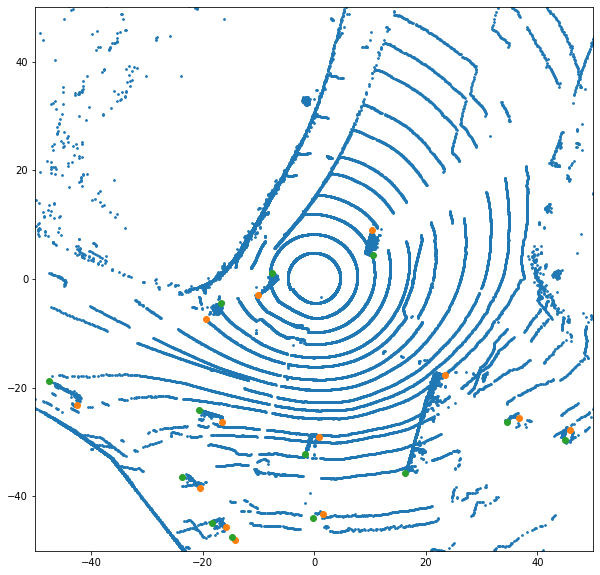

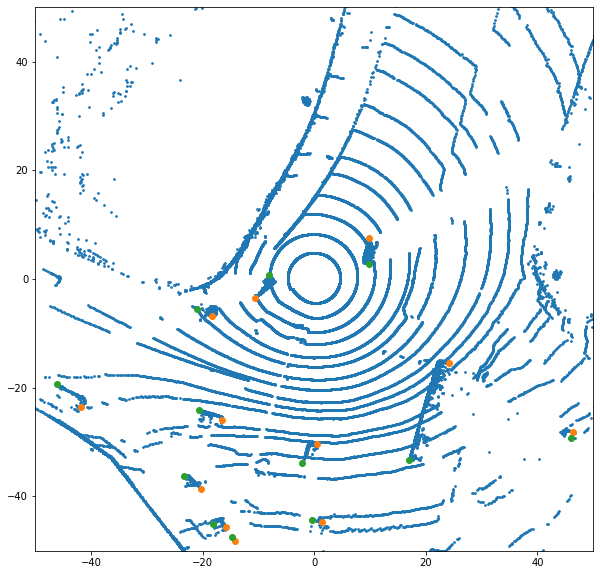

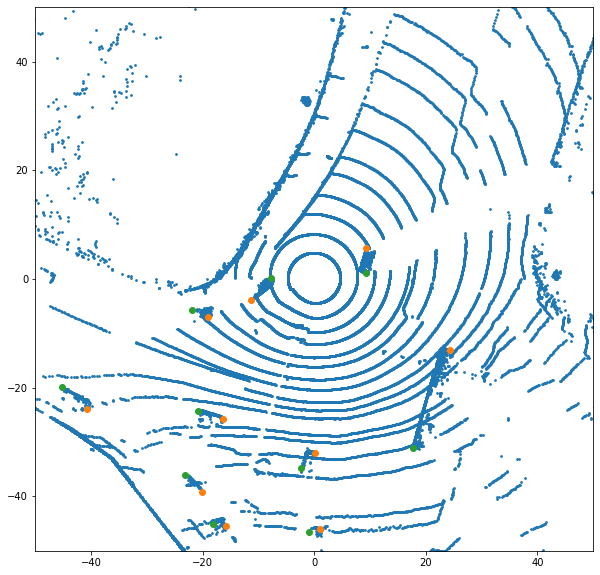

In [83]:
for i in range(600,700):
    Td_map = collector.aggregated_map[i]
    Foreground_map = (Td_map < collector.thred_map)&(Td_map != 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    Background_map = (Td_map >= collector.thred_map)&(Td_map != 0)
    xy_set,uni_label,Labeling_map_new = extract_xy_interval_merging_TR(Labeling_map,Td_map,Background_map)
    pcd = get_pcd_colored(Td_map,Labeling_map_new)
    xy = np.asarray(pcd.points)[:,[0,1]]
    plt.figure(figsize=(10,10))
    plt.scatter(xy[:,0],xy[:,1],s = 3)
    plt.scatter(xy_set[:,0,0],xy_set[:,0,1])
    plt.scatter(xy_set[:,1,0],xy_set[:,1,1])
    plt.ylim(-50,50)
    plt.xlim(-50,50)
    plt.show()

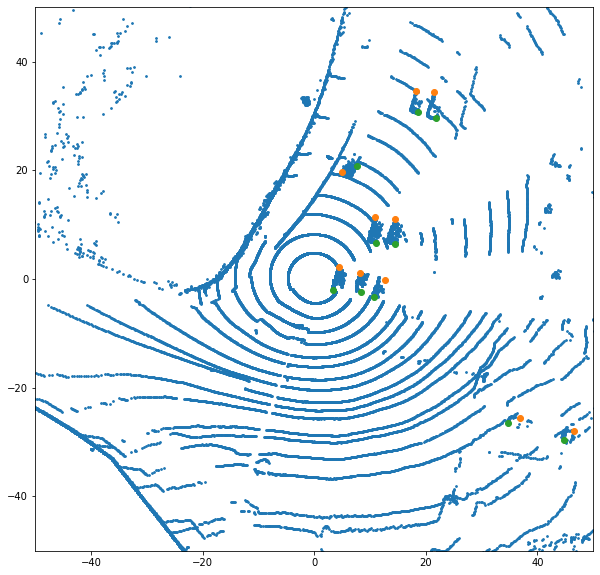

In [67]:
Td_map = collector.aggregated_map[580]
Foreground_map = (Td_map < collector.thred_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= collector.thred_map)&(Td_map != 0)
xy_set,uni_label,Labeling_map_new = extract_xy_interval_merging_TR(Labeling_map,Td_map,Background_map)
pcd = get_pcd_colored(Td_map,Labeling_map_new)
xy = np.asarray(pcd.points)[:,[0,1]]
plt.figure(figsize=(10,10))
plt.scatter(xy[:,0],xy[:,1],s = 3)
plt.scatter(xy_set[:,0,0],xy_set[:,0,1])
plt.scatter(xy_set[:,1,0],xy_set[:,1,1])
plt.ylim(-50,50)
plt.xlim(-50,50)
plt.show()